In [1]:
import numpy as np
import time
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from treeple.datasets import make_trunk_classification
import ydf
import matplotlib.pyplot as plt
from treeple import ObliqueRandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib.cm import ScalarMappable
from matplotlib.colors import ListedColormap
from treeple._lib.sklearn.tree._criterion import Gini
from treeple.tree._oblique_splitter import BestObliqueSplitterTester
from treeple.datasets import make_trunk_classification
import pandas as pd
import math


# Check projection matrix shape in treeple

In [2]:
def plot_proj_existing_data(X, y,
                max_features=10, 
                feature_combinations=1.5,
                plot_fig=True,
                random_state=1):

    criterion = Gini(1, np.array((0, 1)))

    min_samples_leaf = 1
    min_weight_leaf = 0.0
    random_state = np.random.RandomState(random_state)
    n_samples= X.shape[0]
    n_features= X.shape[1]

    #feature_combinations = 3.0
    monotonic_cst = None
    missing_value_feature_mask = None

    # X, y = make_trunk_classification(n_samples=n_samples, n_dim=n_features, n_informative=600, seed=0)
    y = y.reshape(-1,1).astype(np.float64)
    X= X.astype(np.float32)

    sample_weight = np.ones(n_samples)

    splitter = BestObliqueSplitterTester(
        criterion,
        max_features,
        min_samples_leaf,
        min_weight_leaf,
        random_state,
        monotonic_cst,
        feature_combinations,
    )
    splitter.init_test(X, y, sample_weight, missing_value_feature_mask)


    projection_matrix = splitter.sample_projection_matrix_py()
    


    if plot_fig:
        # Visualize the projection matrix
        cmap = ListedColormap(["orange", "white", "green"])

        # Create a heatmap to visualize the indices
        fig, ax = plt.subplots(figsize=(6, 6))

        ax.imshow(projection_matrix, cmap=cmap, aspect=n_features / max_features, interpolation="none")

        ax.set(title="Sampled Projection Matrix", xlabel="Feature Index", ylabel="Projection Vector Index")
        ax.set_xticks(np.arange(n_features))
        ax.set_yticks(np.arange(max_features))
        ax.set_yticklabels(np.arange(max_features, dtype=int) + 1)
        ax.set_xticklabels(np.arange(n_features, dtype=int) + 1)

        # Create a mappable object
        sm = ScalarMappable(cmap=cmap)
        sm.set_array([])  # You can set an empty array or values here

        # Create a color bar with labels for each feature set
        colorbar = fig.colorbar(sm, ax=ax, ticks=[0, 0.5, 1], format="%d")
        colorbar.set_label("Projection Weight")
        colorbar.ax.set_yticklabels(["-1", "0", "1"])

        plt.show()
    print("===========================================================================")
    print("projection matrix shape:", projection_matrix.shape)
    print("Created projection matrix with the following parameters:")
    print(f"n_feature = ", n_features, 
          "\nn_samples = ", n_samples, 
          "\nmax_features = ", max_features, 
          "\nfeature_combinations = ", feature_combinations)
    print("max_features * feature_combinations = ", max_features * feature_combinations)
    print("Number of non-zeros: ",len(projection_matrix.nonzero()[0]))
    return projection_matrix, len(projection_matrix.nonzero()[0])



# Basic functions for training

In [3]:
def prepare_dataframe(X, y):
    df = pd.DataFrame(X)
    df.columns = [str(i) for i in df.columns]  # Convert column names to strings
    df["target"] = y.astype(int)  # Append target column

    return df

In [4]:
## training functions for ydf and treeple

def train_treeple(model, model_name, X_train, X_test, y_train, y_test):
    """
    Train a given model and evaluate its accuracy and training time.
    """
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time

    y_pred = model.predict(X_test)
    if isinstance(y_pred[0], np.ndarray):  # Some models return probabilities
        y_pred = np.argmax(y_pred, axis=1)

    accuracy = accuracy_score(y_test, y_pred)
    # print(f"{model_name}: Accuracy = {accuracy:.4f}, Training Time = {train_time:.4f} sec")
    
    return accuracy, train_time, y_pred


def train_ydf(X_train, y_train, X_test, y_test, params_ydf):
    df_train = prepare_dataframe(X_train, y_train)
    df_test = prepare_dataframe(X_test, y_test)

    learner = ydf.RandomForestLearner(**params_ydf)
    start_time = time.time()
    ydf_model = learner.train(df_train)
    time_ydf = time.time() - start_time
    y_pred = ydf_model.predict(df_test)
    y_pred_class = (y_pred >= 0.5).astype(int) 

    acc_ydf = accuracy_score(y_test, y_pred_class)

    # print(f"YDF | n_dim: {n_dim} | n_tree: {params_ydf['num_trees']} | Accuracy: {acc_ydf:.4f} | Train Time: {time_ydf:.4f} sec")
    return acc_ydf, time_ydf, y_pred_class, ydf_model

# Extract the average number of non-zeros in projection vectors from ydf model outputs

In [5]:
import re
import numpy as np
from scipy.sparse import lil_matrix



def selected_weights(tree_str, n_feature):
    """
    Parses a string representation of a YDF decision tree to extract the projection matrix,
    compute its dimension (number of input features), and count non-zero weights.

    Args:
        tree_str (str): Stringified tree structure starting from the root node.

    Returns:
        weight_at_nodes (scipy.sparse.lil_matrix): Sparse matrix of projections.
        proj_dim (int): Dimensionality of each projection (i.e., number of input features).
        num_nonzeros (int): Total number of non-zero weights in the matrix.
    """
    # Find all attribute-weight pairs
    attr_blocks = re.findall(
        r'attributes=\[([0-9,\s]+)\]\s*,\s*weights=\[([0-9eE+.\-,\s]+)\]',
        tree_str
    )
    # print("num of dense vectors: ", len(attr_blocks))

    projection_rows = []
    max_feature_index = -1
    total_nonzeros = 0

    for attr_str, weight_str in attr_blocks:
        attrs = [int(i.strip()) for i in attr_str.split(',') if i.strip()]
        weights = [float(w.strip()) for w in weight_str.split(',') if w.strip()]
        
        if len(attrs) != len(weights):
            raise ValueError(f"Mismatched attributes and weights: {attrs}, {weights}")
        
        total_nonzeros += len(weights)  # Count all weights (assumed non-zero)
        if attrs:
            max_feature_index = max(max_feature_index, max(attrs))
        
        projection_rows.append((attrs, weights))
    #print(projection_rows)

    
    weight_at_nodes = np.zeros((len(attr_blocks), n_feature))

    for i in range(len(projection_rows)):
        attr = projection_rows[i][0]
        #print(attr)
        weight = projection_rows[i][1]
        for j in range(len(weight)):
            weight_at_nodes[i, attr[j]-1] = weight[j]

    return weight_at_nodes, total_nonzeros


In [6]:
def extract_avg_projection(ydf_model, n_estimator, n_feature):
    

    non_zeros = np.zeros((n_estimator,))
    proj_dim1 = np.zeros((n_estimator,))
    proj_dim2 = np.zeros((n_estimator,))
    for tree_id in range(n_estimator):
        root_str = str(ydf_model.get_tree(tree_id).root)
        #print("*",root_str)
        projection_matrix, n_nonzeros = selected_weights(root_str, n_feature)

        non_zeros[tree_id] = n_nonzeros
        proj_dim1[tree_id] = projection_matrix.shape[0]
        proj_dim2[tree_id] = projection_matrix.shape[1]

    avg_non_zeros = np.mean(non_zeros)
    avg_proj_dim1 = np.mean(proj_dim1)
    avg_proj_dim2 = np.mean(proj_dim2)
    avg_non_zeros_per_vector = avg_non_zeros / avg_proj_dim1
    #print("Average projection matrix shape:", avg_proj_dim1, avg_proj_dim2)
    print("Average nonzeros number in projection vectors among all nodes:", avg_non_zeros_per_vector)

    return avg_proj_dim1, avg_proj_dim2, avg_non_zeros, avg_non_zeros_per_vector

# Initialize parameter settings

In [7]:
# Shared hyperparameters that used for both models
MAX_DEPTH = 10
N_ESTIMATORS = 300
RANDOM_SEED = 42
N_JOBS=-1
BOOTSTRAP = True
MAX_FEATURE = 100
FEATURE_COMBINATIONS = 3.0

### ydf ###
params_ydf = dict()
params_ydf["label"] = "target"
params_ydf["max_depth"] = MAX_DEPTH
params_ydf["num_trees"] = N_ESTIMATORS
params_ydf["random_seed"] = RANDOM_SEED
params_ydf["honest"] = False
params_ydf["bootstrap_size_ratio"] = 1.0
params_ydf["bootstrap_training_dataset"] = BOOTSTRAP
params_ydf["categorical_algorithm"] = "ONE_HOT"
params_ydf["compute_oob_performances"] = False  #oob_score
params_ydf["compute_oob_variable_importances"] = False  ## oob_score
params_ydf["in_split_min_examples_check"] = True
params_ydf["min_examples"] = 1    #min_samples_leaf
params_ydf["keep_non_leaf_label_distribution"] = True   # not sure
params_ydf["max_num_nodes"] = 30
params_ydf["growing_strategy"] = "BEST_FIRST_GLOBAL"
# params_ydf["num_candidate_attributes"] = -1  #0 equivalent to sqrt max_features in treeple
params_ydf["num_candidate_attributes_ratio"] = 1.0
params_ydf["sorting_strategy"] = "IN_NODE" ###
# sparse oblique params
params_ydf["split_axis"] = "SPARSE_OBLIQUE"
params_ydf["sparse_oblique_weights"] = "BINARY"
params_ydf["sparse_oblique_projection_density_factor"] = FEATURE_COMBINATIONS
params_ydf["sparse_oblique_normalization"] = "MIN_MAX"
params_ydf["sparse_oblique_max_num_projections"] = MAX_FEATURE
params_ydf["sparse_oblique_num_projections_exponent"] = 1.0   #2.0
params_ydf["sampling_with_replacement"] = False

### treeple ObliqueRandomForestClassifier ###
params_treeple = {}
params_treeple["n_estimators"] = N_ESTIMATORS
params_treeple["criterion"] = "entropy"
params_treeple["max_depth"] = MAX_DEPTH
params_treeple["min_samples_split"] = 2
params_treeple["min_samples_leaf"] = 1
params_treeple["min_weight_fraction_leaf"] = 0.0
params_treeple["max_features"] = MAX_FEATURE
params_treeple["max_leaf_nodes"] = 30
params_treeple["min_impurity_decrease"] = 0.0
params_treeple["bootstrap"] = BOOTSTRAP
params_treeple["oob_score"] = False
params_treeple["n_jobs"] = N_JOBS
params_treeple["random_state"] = RANDOM_SEED
params_treeple["verbose"] = 0
params_treeple["warm_start"] = False
params_treeple["class_weight"] = None
params_treeple["max_samples"] = None
params_treeple["feature_combinations"] = FEATURE_COMBINATIONS


Edit from main function, get set of params for ydf and treeple given simulation conditions

In [85]:
math.log(64, 4096)

0.5

In [88]:
def get_params(n_tree,                   
            params_treeple, 
            params_ydf,
            target_non_zeros,
            n_rows,
            n_columns,
            n_samples=2000):



    # accs_ydf = np.zeros((len(n_columns), len(n_rows)))
    # times_ydf = np.zeros(accs_ydf.shape)
    # accs_treeple = np.zeros(accs_ydf.shape)
    # times_treeple = np.zeros(accs_ydf.shape)
    # f1_scores = np.zeros(accs_ydf.shape)
    #ydf_params = np.zeros((len(n_columns), len(n_rows)))
    #treeple_params = np.zeros((len(n_columns), len(n_rows)))
    ydf_params = np.empty((len(n_columns), len(n_rows)), dtype=object)
    treeple_params = np.empty((len(n_columns), len(n_rows)), dtype=object)

    # copy the params to avoid overwriting
    params_treeple1 = params_treeple.copy() 
    params_ydf1 = params_ydf.copy()
    params_ydf1["num_trees"] = n_tree
    params_treeple1["n_estimators"] = n_tree
    

    for i, n_column in enumerate(n_columns):
        # n_column matches number of features
        n_dim= n_column


        X, y = make_trunk_classification(n_samples=n_samples, n_dim=n_dim, n_informative=600, seed=0)
        #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # df_train = prepare_dataframe(X_train, y_train)
        # df_test = prepare_dataframe(X_test, y_test)


        for j, n_row in enumerate(n_rows):

            params_ydf1 = params_ydf1.copy()
            params_treeple1 = params_treeple1.copy()
            # n_rows matches number of projections            
            feature_combination = target_non_zeros / n_row
            params_treeple1["max_features"] = n_row
            params_treeple1["feature_combinations"] = feature_combination
            
            params_ydf1["sparse_oblique_max_num_projections"] = int(n_row)
            params_ydf1["sparse_oblique_projection_density_factor"] = feature_combination
            params_ydf1["sparse_oblique_num_projections_exponent"] = math.log(n_row, n_column)
            
            # see if matches the target non-zeros
            _, treeple_n_nonzeros = plot_proj_existing_data(X, y,
                max_features=n_row, 
                feature_combinations=feature_combination,
                plot_fig=False,
                random_state=1)

            print("-----------------------------------------")        
            print(f"Constants: n_dim: {n_dim} | n_tree: {n_tree} | n_samples: {n_samples} | target_non_zeros: {target_non_zeros}")
            print(f"Projection matrix: n_row: {n_row} | n_column: {n_column} | treeple_non_zeros: {treeple_n_nonzeros}")
            print(f"Feature combinations: {feature_combination} | max_features: {n_row}")


            print("------------------------------------------")
            print("YDF parameters:")
            exponent = params_ydf1["sparse_oblique_num_projections_exponent"]
            density_factor = params_ydf1["sparse_oblique_projection_density_factor"]

            num_projection = min(n_row, int(math.ceil(n_column**exponent)+0.5))
            projection_density = density_factor/ n_column
            ydf_nonzeros = num_projection * projection_density * n_column
            print(f"exponent: {exponent} | density_factor: {density_factor} | max_num_projection: {num_projection} | projection_density: {projection_density:.2f}")
            print(f"num of projections: {num_projection} | expected non-zeros: {ydf_nonzeros:.2f}")
            

            ydf_params[i,j] = params_ydf1
            treeple_params[i,j] = params_treeple1
            # acc_temp_ydf=0
            # time_temp_ydf=0

            # acc_temp_treeple=0
            # time_temp_treeple=0

            # f1_temp=0

            # for _ in range(n_rep):
            #     # --- Train YDF ---
            #     acc_ydf, time_ydf, pred_ydf, ydf_model = train_ydf(X_train, y_train, X_test, y_test, params_ydf1)
            #     acc_temp_ydf+=acc_ydf
            #     time_temp_ydf+=time_ydf
            
            #     # --- Train Treeple ---
            #     treeple_model = ObliqueRandomForestClassifier(**params_treeple1)
            #     acc_treeple, time_treeple, pred_treeple = train_treeple(treeple_model, "Treeple", X_train, X_test, y_train, y_test)
            #     acc_temp_treeple+=acc_treeple
            #     time_temp_treeple+=time_treeple

            #     # Calculate F1 score for two predictions
            #     f1_compare = f1_score(pred_ydf, pred_treeple)
            #     f1_temp+=f1_compare
                
            # # check average number of non-zeros per vector
            # print("-----------------------------------------")
            # _,_,_,avg_non_zeros = extract_avg_projection(ydf_model, n_tree, n_dim)
            # print(f"Average non-zeros per projection matrix: {avg_non_zeros*n_row:.2f}")


            # # Store results
            # accs_ydf[i,j] = acc_temp_ydf/n_rep
            # times_ydf[i,j] = time_temp_ydf/n_rep

            # accs_treeple[i,j] = acc_temp_treeple/n_rep
            # times_treeple[i,j] = time_temp_treeple/n_rep

            # f1_scores[i,j] = f1_temp/n_rep

    return treeple_params, ydf_params

# Main experiment function

In [ ]:
def constant_nNonzeros_simulation(n_tree,                   
                                params_treeple, 
                                params_ydf,
                                target_non_zeros,
                                n_rows,
                                n_columns,
                                n_samples=2000, 
                                n_rep=2,
                                plot=False):



    accs_ydf = np.zeros((len(n_columns), len(n_rows)))
    times_ydf = np.zeros(accs_ydf.shape)
    accs_treeple = np.zeros(accs_ydf.shape)
    times_treeple = np.zeros(accs_ydf.shape)
    f1_scores = np.zeros(accs_ydf.shape)

    # copy the params to avoid overwriting
    params_treeple1 = params_treeple.copy() 
    params_ydf1 = params_ydf.copy()
    params_ydf1["num_trees"] = n_tree
    params_treeple1["n_estimators"] = n_tree
    

    for i, n_column in enumerate(n_columns):
        # n_column matches number of features
        n_dim= n_column


        X, y = make_trunk_classification(n_samples=n_samples, n_dim=n_dim, n_informative=600, seed=0)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # df_train = prepare_dataframe(X_train, y_train)
        # df_test = prepare_dataframe(X_test, y_test)


        for j, n_row in enumerate(n_rows):
            # n_rows matches number of projections            
            feature_combination = target_non_zeros / n_row
            params_treeple1["max_features"] = n_row
            params_treeple1["feature_combinations"] = feature_combination
            
            params_ydf1["sparse_oblique_max_num_projections"] = int(n_row)
            params_ydf1["sparse_oblique_projection_density_factor"] = feature_combination
            #params_ydf1["sparse_oblique_num_projections_exponent"] = math.log(n_column, n_row) + 1.0
            params_ydf1["sparse_oblique_num_projections_exponent"] = math.log(n_row, n_column)

            # see if matches the target non-zeros
            _, treeple_n_nonzeros = plot_proj_existing_data(X, y,
                max_features=n_row, 
                feature_combinations=feature_combination,
                plot_fig=False,
                random_state=1)

            print("-----------------------------------------")        
            print(f"Constants: n_dim: {n_dim} | n_tree: {n_tree} | n_samples: {n_samples} | target_non_zeros: {target_non_zeros} | n_rep: {n_rep}")
            print(f"Projection matrix: n_row: {n_row} | n_column: {n_column} | treeple_non_zeros: {treeple_n_nonzeros}")
            print(f"Feature combinations: {feature_combination} | max_features: {n_row}")


            print("------------------------------------------")
            print("YDF parameters:")
            exponent = params_ydf1["sparse_oblique_num_projections_exponent"]
            density_factor = params_ydf1["sparse_oblique_projection_density_factor"]

            num_projection = min(n_row, int(math.ceil(n_column**exponent)+0.5))
            projection_density = density_factor/ n_column
            ydf_nonzeros = num_projection * projection_density * n_column
            print(f"exponent: {exponent} | density_factor: {density_factor} | max_num_projection: {num_projection} | projection_density: {projection_density:.2f}")
            print(f"num of projections: {num_projection} | expected non-zeros: {ydf_nonzeros:.2f}")
            
            acc_temp_ydf=0
            time_temp_ydf=0

            acc_temp_treeple=0
            time_temp_treeple=0

            f1_temp=0

            for _ in range(n_rep):
                # --- Train YDF ---
                acc_ydf, time_ydf, pred_ydf, ydf_model = train_ydf(X_train, y_train, X_test, y_test, params_ydf1)
                acc_temp_ydf+=acc_ydf
                time_temp_ydf+=time_ydf
            
                # --- Train Treeple ---
                treeple_model = ObliqueRandomForestClassifier(**params_treeple1)
                acc_treeple, time_treeple, pred_treeple = train_treeple(treeple_model, "Treeple", X_train, X_test, y_train, y_test)
                acc_temp_treeple+=acc_treeple
                time_temp_treeple+=time_treeple

                # Calculate F1 score for two predictions
                f1_compare = f1_score(pred_ydf, pred_treeple)
                f1_temp+=f1_compare
                
            # check average number of non-zeros per vector
            print("-----------------------------------------")
            _,_,_,avg_non_zeros = extract_avg_projection(ydf_model, n_tree, n_dim)
            print(f"Average non-zeros per projection matrix: {avg_non_zeros*n_row:.2f}")


            # Store results
            accs_ydf[i,j] = acc_temp_ydf/n_rep
            times_ydf[i,j] = time_temp_ydf/n_rep

            accs_treeple[i,j] = acc_temp_treeple/n_rep
            times_treeple[i,j] = time_temp_treeple/n_rep

            f1_scores[i,j] = f1_temp/n_rep

    return accs_ydf, times_ydf, accs_treeple, times_treeple, f1_scores, params_ydf1

# Run experiment

## toy tests

In [26]:
n_rows = np.ones(3)
n_rows[0] = 32
n_rows.shape
for i in range(0,n_rows.shape[0]-1):
    n_rows[i+1] = n_rows[i]*2
n_columns = n_rows

n_rows = n_rows.astype(int)
n_columns = n_columns.astype(int)
n_rows

accs_ydf, times_ydf, accs_treeple, times_treeple, f1_scores, _ = constant_nNonzeros_simulation(
    n_tree=N_ESTIMATORS, 
    params_treeple=params_treeple, 
    params_ydf=params_ydf,
    target_non_zeros=256,  # Target number of non-zeros in the projection matrix
    n_rows=n_rows,          # Number of rows in the projection matrix
    n_columns=n_columns,    # Number of columns in the projection matrix
    n_samples=2000,         # Number of samples
    n_rep=1,                # Number of repetitions for averaging
    plot=False               # Whether to plot the projection matrix
)

projection matrix shape: (32, 32)
Created projection matrix with the following parameters:
n_feature =  32 
n_samples =  2000 
max_features =  32 
feature_combinations =  8.0
max_features * feature_combinations =  256.0
Number of non-zeros:  256
-----------------------------------------
Constants: n_dim: 32 | n_tree: 300 | n_samples: 2000 | target_non_zeros: 256 | n_rep: 1
Projection matrix: n_row: 32 | n_column: 32 | treeple_non_zeros: 256
Feature combinations: 8.0 | max_features: 32
------------------------------------------
YDF parameters:
exponent: 2.0 | density_factor: 8.0 | max_num_projection: 32 | projection_density: 0.25
num of projections: 32 | expected non-zeros: 256.00
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\treeple\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 32. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.433160
-----------------------------------------
Average nonzeros number in projection vectors among all nodes: 7.94367816091954
Average non-zeros per projection matrix: 254.20
projection matrix shape: (64, 32)
Created projection matrix with the following parameters:
n_feature =  32 
n_samples =  2000 
max_features =  64 
feature_combinations =  4.0
max_features * feature_combinations =  256.0
Number of non-zeros:  256
-----------------------------------------
Constants: n_dim: 32 | n_tree: 300 | n_samples: 2000 | target_non_zeros: 256 | n_rep: 1
Projection matrix: n_row: 64 | n_column: 32 | treeple_non_zeros: 256
Feature combinations: 4.0 | max_features: 64
------------------------------------------
YDF parameters:
exponent: 1.8333333333333335 | density_factor: 4.0 | max_num_projection: 64 | projection_density: 0.12
num of projections: 64 | expected non-zeros: 256.00
Train model on 1600 examples
Model trained in 0:00:00.748772
---------------------------------

c:\Users\clark\anaconda3\envs\treeple\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 64. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.477868
-----------------------------------------
Average nonzeros number in projection vectors among all nodes: 7.948505747126436
Average non-zeros per projection matrix: 254.35
projection matrix shape: (64, 64)
Created projection matrix with the following parameters:
n_feature =  64 
n_samples =  2000 
max_features =  64 
feature_combinations =  4.0
max_features * feature_combinations =  256.0
Number of non-zeros:  256
-----------------------------------------
Constants: n_dim: 64 | n_tree: 300 | n_samples: 2000 | target_non_zeros: 256 | n_rep: 1
Projection matrix: n_row: 64 | n_column: 64 | treeple_non_zeros: 256
Feature combinations: 4.0 | max_features: 64
------------------------------------------
YDF parameters:
exponent: 2.0 | density_factor: 4.0 | max_num_projection: 64 | projection_density: 0.06
num of projections: 64 | expected non-zeros: 256.00
Train model on 1600 examples
Model trained in 0:00:00.809590
-----------------------------------------
Avera

c:\Users\clark\anaconda3\envs\treeple\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 128. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.511811
-----------------------------------------
Average nonzeros number in projection vectors among all nodes: 7.974252873563218
Average non-zeros per projection matrix: 255.18
projection matrix shape: (64, 128)
Created projection matrix with the following parameters:
n_feature =  128 
n_samples =  2000 
max_features =  64 
feature_combinations =  4.0
max_features * feature_combinations =  256.0
Number of non-zeros:  256
-----------------------------------------
Constants: n_dim: 128 | n_tree: 300 | n_samples: 2000 | target_non_zeros: 256 | n_rep: 1
Projection matrix: n_row: 64 | n_column: 128 | treeple_non_zeros: 256
Feature combinations: 4.0 | max_features: 64
------------------------------------------
YDF parameters:
exponent: 2.166666666666667 | density_factor: 4.0 | max_num_projection: 64 | projection_density: 0.03
num of projections: 64 | expected non-zeros: 256.00
Train model on 1600 examples
Model trained in 0:00:00.847783
-----------------------------

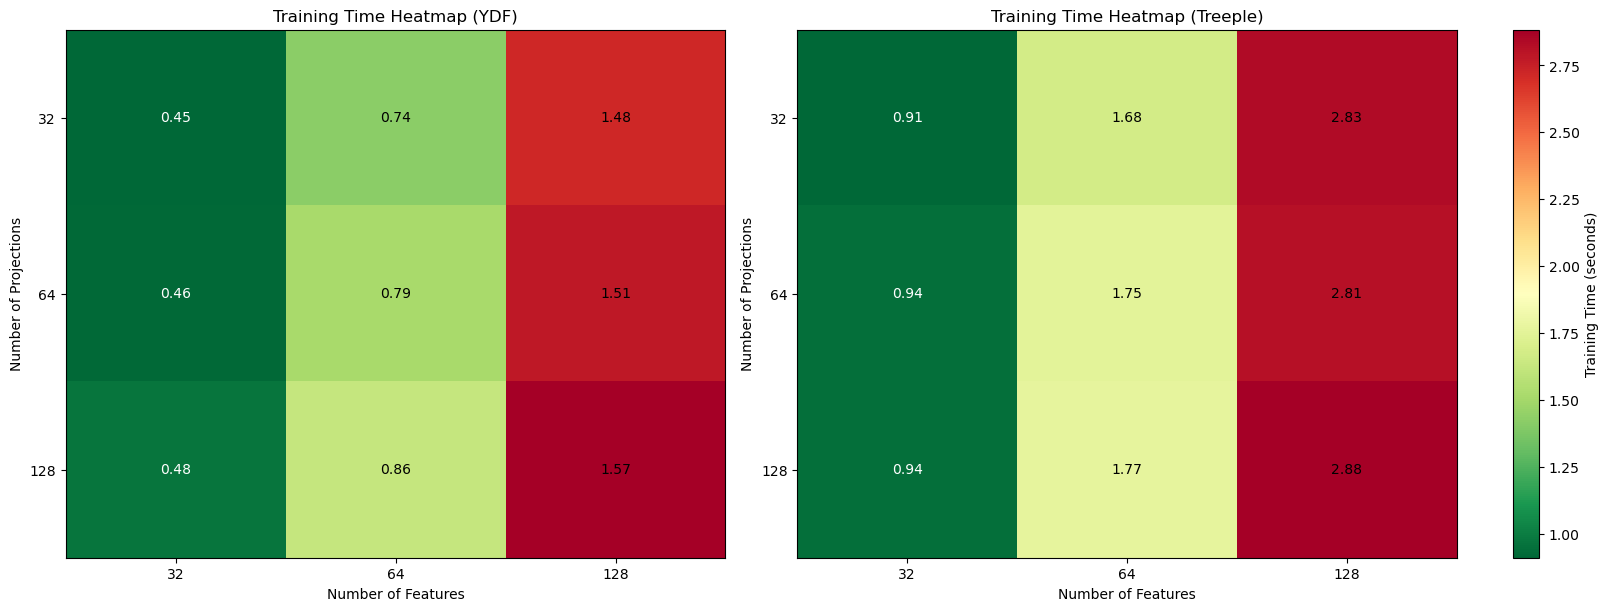

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), constrained_layout=True)

# Plot the heatmap for YDF
cax1 = axes[0].imshow(times_ydf, cmap='RdYlGn_r', aspect='auto')
axes[0].set_title('Training Time Heatmap (YDF)')
axes[0].set_xlabel('Number of Features')
axes[0].set_ylabel('Number of Projections')
axes[0].set_xticks(np.arange(len(n_columns)))
axes[0].set_yticks(np.arange(len(n_rows)))
axes[0].set_xticklabels(n_columns)
axes[0].set_yticklabels(n_rows)

# Plot the heatmap for Treeple
cax2 = axes[1].imshow(times_treeple, cmap='RdYlGn_r', aspect='auto')
axes[1].set_title('Training Time Heatmap (Treeple)')
axes[1].set_xlabel('Number of Features')
axes[1].set_ylabel('Number of Projections')
axes[1].set_xticks(np.arange(len(n_columns)))
axes[1].set_yticks(np.arange(len(n_rows)))
axes[1].set_xticklabels(n_columns)
axes[1].set_yticklabels(n_rows)

# Set shared color bar
cbar = fig.colorbar(cax2, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Training Time (seconds)')

# Annotate each block with the training time value for YDF
for i in range(len(n_rows)):
    for j in range(len(n_columns)):
        text_color = 'black' if cax1.norm(times_ydf[i, j]) > 0.1 else 'white'
        axes[0].text(j, i, f"{times_ydf[i, j]:.2f}", ha='center', va='center', color=text_color)

# Annotate each block with the training time value for Treeple
for i in range(len(n_rows)):
    for j in range(len(n_columns)):
        text_color = 'black' if cax2.norm(times_treeple[i, j]) > 0.1 else 'white'
        axes[1].text(j, i, f"{times_treeple[i, j]:.2f}", ha='center', va='center', color=text_color)

plt.show()

## first run, with 5 row / column values, 32-512

In [18]:
n_rows = np.ones(5)
n_rows[0] = 32
n_rows.shape
for i in range(0,n_rows.shape[0]-1):
    n_rows[i+1] = n_rows[i]*2
n_columns = n_rows

n_rows = n_rows.astype(int)
n_columns = n_columns.astype(int)
n_rows

array([ 32,  64, 128, 256, 512])

In [19]:
accs_ydf, times_ydf, accs_treeple, times_treeple, f1_scores, _ = constant_nNonzeros_simulation(
    n_tree=N_ESTIMATORS, 
    params_treeple=params_treeple, 
    params_ydf=params_ydf,
    target_non_zeros=1024,  # Target number of non-zeros in the projection matrix
    n_rows=n_rows,          # Number of rows in the projection matrix
    n_columns=n_columns,    # Number of columns in the projection matrix
    n_samples=2000,         # Number of samples
    n_rep=1,                # Number of repetitions for averaging
    plot=False               # Whether to plot the projection matrix
)

projection matrix shape: (32, 32)
Created projection matrix with the following parameters:
n_feature =  32 
n_samples =  2000 
max_features =  32 
feature_combinations =  32.0
max_features * feature_combinations =  1024.0
Number of non-zeros:  1024
-----------------------------------------
Constants: n_dim: 32 | n_tree: 300 | n_samples: 2000 | target_non_zeros: 1024 | n_rep: 1
Projection matrix: n_row: 32 | n_column: 32 | treeple_non_zeros: 1024
Feature combinations: 32.0 | max_features: 32
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\treeple\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 32. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.666902
-----------------------------------------
Average nonzeros number in projection vectors among all nodes: 32.0
Average non-zeros per projection matrix: 1024.00
projection matrix shape: (64, 32)
Created projection matrix with the following parameters:
n_feature =  32 
n_samples =  2000 
max_features =  64 
feature_combinations =  16.0
max_features * feature_combinations =  1024.0
Number of non-zeros:  1024
-----------------------------------------
Constants: n_dim: 32 | n_tree: 300 | n_samples: 2000 | target_non_zeros: 1024 | n_rep: 1
Projection matrix: n_row: 64 | n_column: 32 | treeple_non_zeros: 1024
Feature combinations: 16.0 | max_features: 64
Train model on 1600 examples
Model trained in 0:00:00.960695
-----------------------------------------
Average nonzeros number in projection vectors among all nodes: 16.028390804597702
Average non-zeros per projection matrix: 1025.82
projection matrix shape: (128, 32)
Created projection matrix with the following

c:\Users\clark\anaconda3\envs\treeple\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 64. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.647165
-----------------------------------------
Average nonzeros number in projection vectors among all nodes: 31.95977011494253
Average non-zeros per projection matrix: 1022.71
projection matrix shape: (64, 64)
Created projection matrix with the following parameters:
n_feature =  64 
n_samples =  2000 
max_features =  64 
feature_combinations =  16.0
max_features * feature_combinations =  1024.0
Number of non-zeros:  1024
-----------------------------------------
Constants: n_dim: 64 | n_tree: 300 | n_samples: 2000 | target_non_zeros: 1024 | n_rep: 1
Projection matrix: n_row: 64 | n_column: 64 | treeple_non_zeros: 1024
Feature combinations: 16.0 | max_features: 64
Train model on 1600 examples
Model trained in 0:00:00.961116
-----------------------------------------
Average nonzeros number in projection vectors among all nodes: 16.04597701149425
Average non-zeros per projection matrix: 1026.94
projection matrix shape: (128, 64)
Created projection matrix with t

c:\Users\clark\anaconda3\envs\treeple\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 128. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.724794
-----------------------------------------
Average nonzeros number in projection vectors among all nodes: 31.924482758620687
Average non-zeros per projection matrix: 1021.58
projection matrix shape: (64, 128)
Created projection matrix with the following parameters:
n_feature =  128 
n_samples =  2000 
max_features =  64 
feature_combinations =  16.0
max_features * feature_combinations =  1024.0
Number of non-zeros:  1024
-----------------------------------------
Constants: n_dim: 128 | n_tree: 300 | n_samples: 2000 | target_non_zeros: 1024 | n_rep: 1
Projection matrix: n_row: 64 | n_column: 128 | treeple_non_zeros: 1024
Feature combinations: 16.0 | max_features: 64
Train model on 1600 examples
Model trained in 0:00:01.071225
-----------------------------------------
Average nonzeros number in projection vectors among all nodes: 15.979080459770115
Average non-zeros per projection matrix: 1022.66
projection matrix shape: (128, 128)
Created projection matrix

c:\Users\clark\anaconda3\envs\treeple\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 256. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.780003
-----------------------------------------
Average nonzeros number in projection vectors among all nodes: 31.988160919540228
Average non-zeros per projection matrix: 1023.62
projection matrix shape: (64, 256)
Created projection matrix with the following parameters:
n_feature =  256 
n_samples =  2000 
max_features =  64 
feature_combinations =  16.0
max_features * feature_combinations =  1024.0
Number of non-zeros:  1024
-----------------------------------------
Constants: n_dim: 256 | n_tree: 300 | n_samples: 2000 | target_non_zeros: 1024 | n_rep: 1
Projection matrix: n_row: 64 | n_column: 256 | treeple_non_zeros: 1024
Feature combinations: 16.0 | max_features: 64
Train model on 1600 examples
Model trained in 0:00:01.196625
-----------------------------------------
Average nonzeros number in projection vectors among all nodes: 15.919080459770115
Average non-zeros per projection matrix: 1018.82
projection matrix shape: (128, 256)
Created projection matrix

c:\Users\clark\anaconda3\envs\treeple\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 512. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.904408
-----------------------------------------
Average nonzeros number in projection vectors among all nodes: 32.07206896551724
Average non-zeros per projection matrix: 1026.31
projection matrix shape: (64, 512)
Created projection matrix with the following parameters:
n_feature =  512 
n_samples =  2000 
max_features =  64 
feature_combinations =  16.0
max_features * feature_combinations =  1024.0
Number of non-zeros:  1024
-----------------------------------------
Constants: n_dim: 512 | n_tree: 300 | n_samples: 2000 | target_non_zeros: 1024 | n_rep: 1
Projection matrix: n_row: 64 | n_column: 512 | treeple_non_zeros: 1024
Feature combinations: 16.0 | max_features: 64
Train model on 1600 examples
Model trained in 0:00:01.374541
-----------------------------------------
Average nonzeros number in projection vectors among all nodes: 15.96528735632184
Average non-zeros per projection matrix: 1021.78
projection matrix shape: (128, 512)
Created projection matrix w

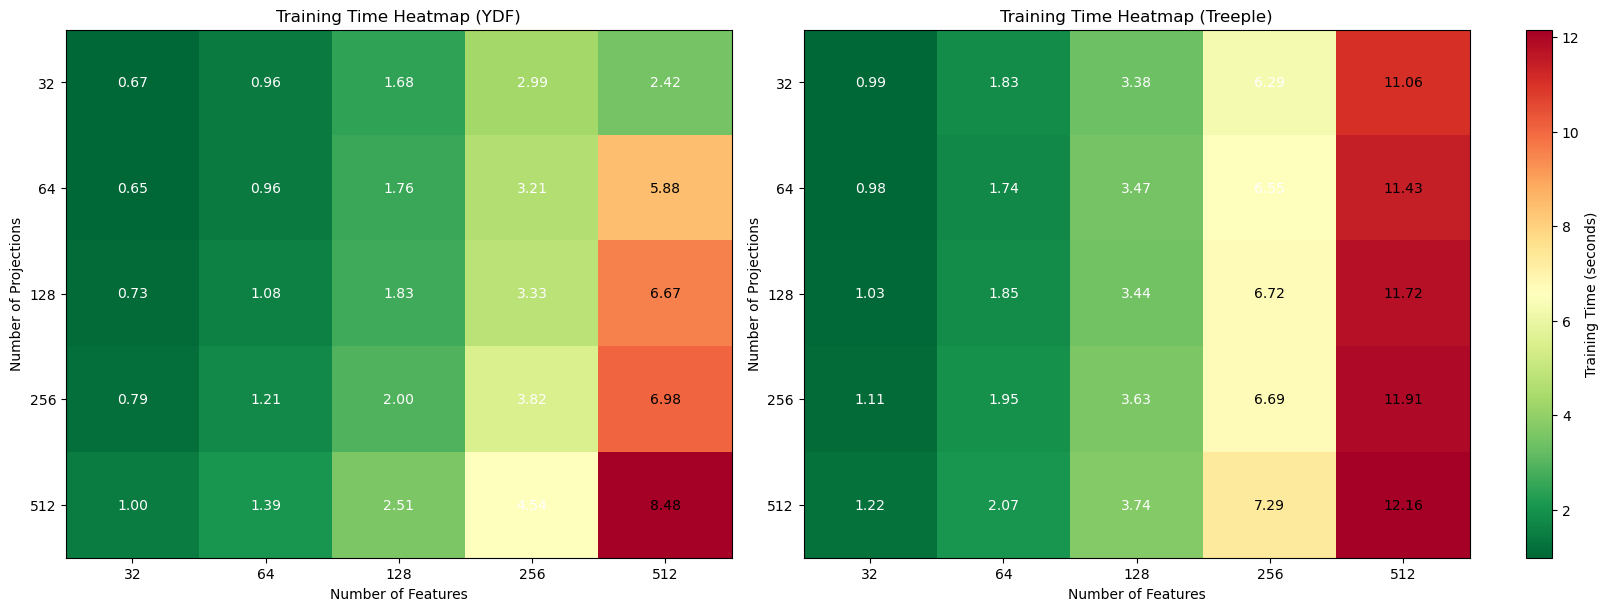

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), constrained_layout=True)

# Plot the heatmap for YDF
cax1 = axes[0].imshow(times_ydf, cmap='RdYlGn_r', aspect='auto')
axes[0].set_title('Training Time Heatmap (YDF)')
axes[0].set_xlabel('Number of Features')
axes[0].set_ylabel('Number of Projections')
axes[0].set_xticks(np.arange(len(n_columns)))
axes[0].set_yticks(np.arange(len(n_rows)))
axes[0].set_xticklabels(n_columns)
axes[0].set_yticklabels(n_rows)

# Plot the heatmap for Treeple
cax2 = axes[1].imshow(times_treeple, cmap='RdYlGn_r', aspect='auto')
axes[1].set_title('Training Time Heatmap (Treeple)')
axes[1].set_xlabel('Number of Features')
axes[1].set_ylabel('Number of Projections')
axes[1].set_xticks(np.arange(len(n_columns)))
axes[1].set_yticks(np.arange(len(n_rows)))
axes[1].set_xticklabels(n_columns)
axes[1].set_yticklabels(n_rows)

# Set shared color bar
cbar = fig.colorbar(cax2, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Training Time (seconds)')

# Annotate each block with the training time value for YDF
for i in range(len(n_rows)):
    for j in range(len(n_columns)):
        text_color = 'black' if cax1.norm(times_ydf[i, j]) > 0.5 else 'white'
        axes[0].text(j, i, f"{times_ydf[i, j]:.2f}", ha='center', va='center', color=text_color)

# Annotate each block with the training time value for Treeple
for i in range(len(n_rows)):
    for j in range(len(n_columns)):
        text_color = 'black' if cax2.norm(times_treeple[i, j]) > 0.5 else 'white'
        axes[1].text(j, i, f"{times_treeple[i, j]:.2f}", ha='center', va='center', color=text_color)

plt.show()

## second run, 64-2048

In [ ]:
n_rows = np.ones(6)
n_rows[0] = 64
n_rows.shape
for i in range(0,n_rows.shape[0]-1):
    n_rows[i+1] = n_rows[i]*2
n_columns = n_rows

n_rows = n_rows.astype(int)
n_columns = n_columns.astype(int)
n_rows

accs_ydf, times_ydf, accs_treeple, times_treeple, f1_scores, params_ydf_check = constant_nNonzeros_simulation(
    n_tree=200, 
    params_treeple=params_treeple, 
    params_ydf=params_ydf,
    target_non_zeros=2048,  # Target number of non-zeros in the projection matrix
    n_rows=n_rows,          # Number of rows in the projection matrix
    n_columns=n_columns,    # Number of columns in the projection matrix
    n_samples=2000,         # Number of samples
    n_rep=1,                # Number of repetitions for averaging
    plot=False               # Whether to plot the projection matrix
)

projection matrix shape: (64, 64)
Created projection matrix with the following parameters:
n_feature =  64 
n_samples =  2000 
max_features =  64 
feature_combinations =  32.0
max_features * feature_combinations =  2048.0
Number of non-zeros:  2048
-----------------------------------------
Constants: n_dim: 64 | n_tree: 200 | n_samples: 2000 | target_non_zeros: 2048 | n_rep: 1
Projection matrix: n_row: 64 | n_column: 64 | treeple_non_zeros: 2048
Feature combinations: 32.0 | max_features: 64
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\treeple\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 64. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.855619
-----------------------------------------
Average nonzeros number in projection vectors among all nodes: 31.986034482758622
Average non-zeros per projection matrix: 2047.11
projection matrix shape: (128, 64)
Created projection matrix with the following parameters:
n_feature =  64 
n_samples =  2000 
max_features =  128 
feature_combinations =  16.0
max_features * feature_combinations =  2048.0
Number of non-zeros:  2048
-----------------------------------------
Constants: n_dim: 64 | n_tree: 200 | n_samples: 2000 | target_non_zeros: 2048 | n_rep: 1
Projection matrix: n_row: 128 | n_column: 64 | treeple_non_zeros: 2048
Feature combinations: 16.0 | max_features: 128
Train model on 1600 examples
Model trained in 0:00:01.236404
-----------------------------------------
Average nonzeros number in projection vectors among all nodes: 15.938620689655174
Average non-zeros per projection matrix: 2040.14
projection matrix shape: (256, 64)
Created projection matrix 

c:\Users\clark\anaconda3\envs\treeple\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 128. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.857909
-----------------------------------------
Average nonzeros number in projection vectors among all nodes: 31.823103448275862
Average non-zeros per projection matrix: 2036.68
projection matrix shape: (128, 128)
Created projection matrix with the following parameters:
n_feature =  128 
n_samples =  2000 
max_features =  128 
feature_combinations =  16.0
max_features * feature_combinations =  2048.0
Number of non-zeros:  2048
-----------------------------------------
Constants: n_dim: 128 | n_tree: 200 | n_samples: 2000 | target_non_zeros: 2048 | n_rep: 1
Projection matrix: n_row: 128 | n_column: 128 | treeple_non_zeros: 2048
Feature combinations: 16.0 | max_features: 128
Train model on 1600 examples
Model trained in 0:00:01.313890
-----------------------------------------
Average nonzeros number in projection vectors among all nodes: 16.003103448275862
Average non-zeros per projection matrix: 2048.40
projection matrix shape: (256, 128)
Created projection ma

c:\Users\clark\anaconda3\envs\treeple\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 256. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.951497
-----------------------------------------
Average nonzeros number in projection vectors among all nodes: 31.92706896551724
Average non-zeros per projection matrix: 2043.33
projection matrix shape: (128, 256)
Created projection matrix with the following parameters:
n_feature =  256 
n_samples =  2000 
max_features =  128 
feature_combinations =  16.0
max_features * feature_combinations =  2048.0
Number of non-zeros:  2048
-----------------------------------------
Constants: n_dim: 256 | n_tree: 200 | n_samples: 2000 | target_non_zeros: 2048 | n_rep: 1
Projection matrix: n_row: 128 | n_column: 256 | treeple_non_zeros: 2048
Feature combinations: 16.0 | max_features: 128
Train model on 1600 examples
Model trained in 0:00:01.481894
-----------------------------------------
Average nonzeros number in projection vectors among all nodes: 15.862413793103448
Average non-zeros per projection matrix: 2030.39
projection matrix shape: (256, 256)
Created projection mat

c:\Users\clark\anaconda3\envs\treeple\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 512. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:01.119164
-----------------------------------------
Average nonzeros number in projection vectors among all nodes: 31.968620689655175
Average non-zeros per projection matrix: 2045.99
projection matrix shape: (128, 512)
Created projection matrix with the following parameters:
n_feature =  512 
n_samples =  2000 
max_features =  128 
feature_combinations =  16.0
max_features * feature_combinations =  2048.0
Number of non-zeros:  2048
-----------------------------------------
Constants: n_dim: 512 | n_tree: 200 | n_samples: 2000 | target_non_zeros: 2048 | n_rep: 1
Projection matrix: n_row: 128 | n_column: 512 | treeple_non_zeros: 2048
Feature combinations: 16.0 | max_features: 128
Train model on 1600 examples
Model trained in 0:00:01.735551
-----------------------------------------
Average nonzeros number in projection vectors among all nodes: 15.924310344827587
Average non-zeros per projection matrix: 2038.31
projection matrix shape: (256, 512)
Created projection ma

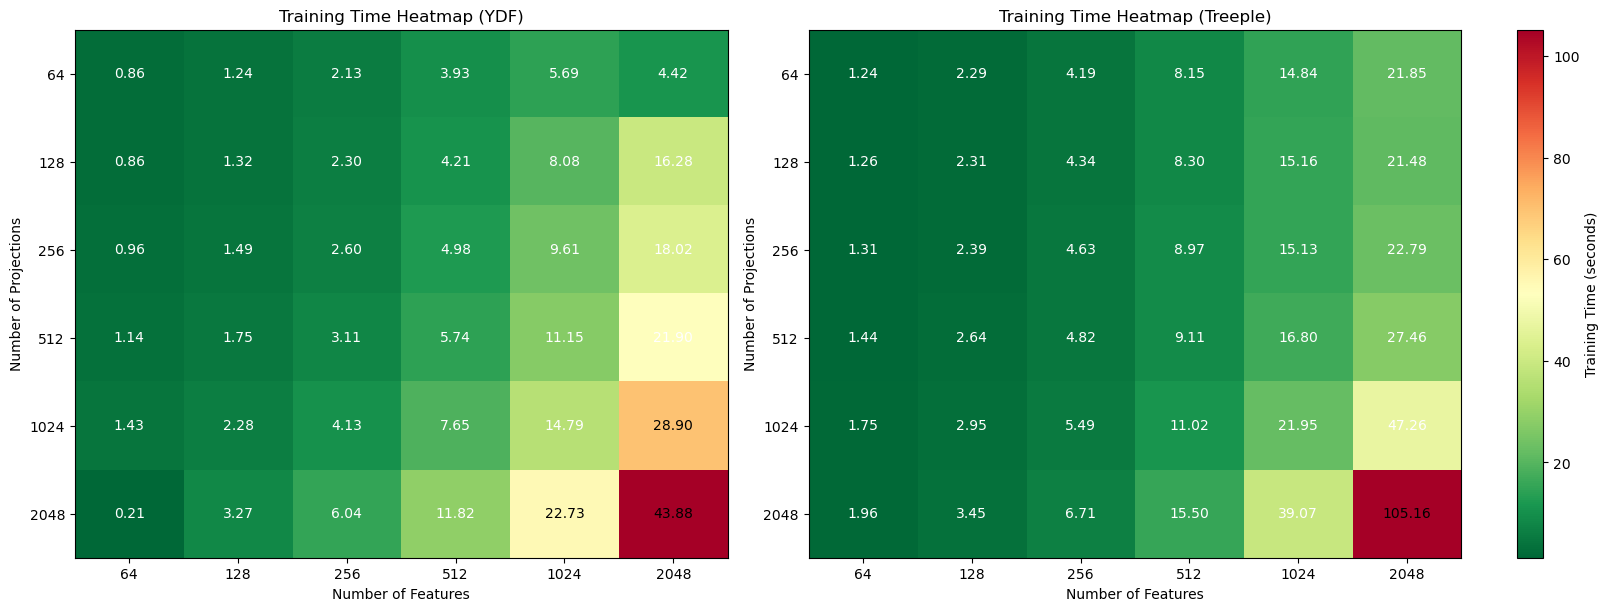

In [111]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), constrained_layout=True)

# Plot the heatmap for YDF
cax1 = axes[0].imshow(times_ydf, cmap='RdYlGn_r', aspect='auto')
axes[0].set_title('Training Time Heatmap (YDF)')
axes[0].set_xlabel('Number of Features')
axes[0].set_ylabel('Number of Projections')
axes[0].set_xticks(np.arange(len(n_columns)))
axes[0].set_yticks(np.arange(len(n_rows)))
axes[0].set_xticklabels(n_columns)
axes[0].set_yticklabels(n_rows)

# Plot the heatmap for Treeple
cax2 = axes[1].imshow(times_treeple, cmap='RdYlGn_r', aspect='auto')
axes[1].set_title('Training Time Heatmap (Treeple)')
axes[1].set_xlabel('Number of Features')
axes[1].set_ylabel('Number of Projections')
axes[1].set_xticks(np.arange(len(n_columns)))
axes[1].set_yticks(np.arange(len(n_rows)))
axes[1].set_xticklabels(n_columns)
axes[1].set_yticklabels(n_rows)

# Set shared color bar
cbar = fig.colorbar(cax2, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Training Time (seconds)')

# Annotate each block with the training time value for YDF
for i in range(len(n_rows)):
    for j in range(len(n_columns)):
        text_color = 'black' if cax1.norm(times_ydf[i, j]) > 0.5 else 'white'
        axes[0].text(j, i, f"{times_ydf[i, j]:.2f}", ha='center', va='center', color=text_color)

# Annotate each block with the training time value for Treeple
for i in range(len(n_rows)):
    for j in range(len(n_columns)):
        text_color = 'black' if cax2.norm(times_treeple[i, j]) > 0.5 else 'white'
        axes[1].text(j, i, f"{times_treeple[i, j]:.2f}", ha='center', va='center', color=text_color)

plt.show()

## Third run, 64-4096

In [103]:
n_rows = np.ones(7)
n_rows[0] = 64
n_rows.shape
for i in range(0,n_rows.shape[0]-1):
    n_rows[i+1] = n_rows[i]*2
n_columns = n_rows

n_rows = n_rows.astype(int)
n_columns = n_columns.astype(int)
n_rows

accs_ydf, times_ydf, accs_treeple, times_treeple, f1_scores, params_ydf_check = constant_nNonzeros_simulation(
    n_tree=200, 
    params_treeple=params_treeple, 
    params_ydf=params_ydf,
    target_non_zeros=4096,  # Target number of non-zeros in the projection matrix
    n_rows=n_rows,          # Number of rows in the projection matrix
    n_columns=n_columns,    # Number of columns in the projection matrix
    n_samples=2000,         # Number of samples
    n_rep=1,                # Number of repetitions for averaging
    plot=False               # Whether to plot the projection matrix
)

projection matrix shape: (64, 64)
Created projection matrix with the following parameters:
n_feature =  64 
n_samples =  2000 
max_features =  64 
feature_combinations =  64.0
max_features * feature_combinations =  4096.0
Number of non-zeros:  4096
-----------------------------------------
Constants: n_dim: 64 | n_tree: 200 | n_samples: 2000 | target_non_zeros: 4096 | n_rep: 1
Projection matrix: n_row: 64 | n_column: 64 | treeple_non_zeros: 4096
Feature combinations: 64.0 | max_features: 64
------------------------------------------
YDF parameters:
exponent: 1.0 | density_factor: 64.0 | max_num_projection: 64 | projection_density: 1.00
num of projections: 64 | expected non-zeros: 4096.00
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\treeple\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 64. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:01.260403
-----------------------------------------
Average nonzeros number in projection vectors among all nodes: 64.0
Average non-zeros per projection matrix: 4096.00
projection matrix shape: (128, 64)
Created projection matrix with the following parameters:
n_feature =  64 
n_samples =  2000 
max_features =  128 
feature_combinations =  32.0
max_features * feature_combinations =  4096.0
Number of non-zeros:  4096
-----------------------------------------
Constants: n_dim: 64 | n_tree: 200 | n_samples: 2000 | target_non_zeros: 4096 | n_rep: 1
Projection matrix: n_row: 128 | n_column: 64 | treeple_non_zeros: 4096
Feature combinations: 32.0 | max_features: 128
------------------------------------------
YDF parameters:
exponent: 1.1666666666666667 | density_factor: 32.0 | max_num_projection: 128 | projection_density: 0.50
num of projections: 128 | expected non-zeros: 4096.00
Train model on 1600 examples
Model trained in 0:00:01.612167
------------------------------

c:\Users\clark\anaconda3\envs\treeple\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 128. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:01.289658
-----------------------------------------
Average nonzeros number in projection vectors among all nodes: 64.04396551724139
Average non-zeros per projection matrix: 4098.81
projection matrix shape: (128, 128)
Created projection matrix with the following parameters:
n_feature =  128 
n_samples =  2000 
max_features =  128 
feature_combinations =  32.0
max_features * feature_combinations =  4096.0
Number of non-zeros:  4096
-----------------------------------------
Constants: n_dim: 128 | n_tree: 200 | n_samples: 2000 | target_non_zeros: 4096 | n_rep: 1
Projection matrix: n_row: 128 | n_column: 128 | treeple_non_zeros: 4096
Feature combinations: 32.0 | max_features: 128
------------------------------------------
YDF parameters:
exponent: 1.0 | density_factor: 32.0 | max_num_projection: 128 | projection_density: 0.25
num of projections: 128 | expected non-zeros: 4096.00
Train model on 1600 examples
Model trained in 0:00:01.719057
----------------------------

c:\Users\clark\anaconda3\envs\treeple\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 256. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:01.387454
-----------------------------------------
Average nonzeros number in projection vectors among all nodes: 64.07379310344828
Average non-zeros per projection matrix: 4100.72
projection matrix shape: (128, 256)
Created projection matrix with the following parameters:
n_feature =  256 
n_samples =  2000 
max_features =  128 
feature_combinations =  32.0
max_features * feature_combinations =  4096.0
Number of non-zeros:  4096
-----------------------------------------
Constants: n_dim: 256 | n_tree: 200 | n_samples: 2000 | target_non_zeros: 4096 | n_rep: 1
Projection matrix: n_row: 128 | n_column: 256 | treeple_non_zeros: 4096
Feature combinations: 32.0 | max_features: 128
------------------------------------------
YDF parameters:
exponent: 0.875 | density_factor: 32.0 | max_num_projection: 128 | projection_density: 0.12
num of projections: 128 | expected non-zeros: 4096.00
Train model on 1600 examples
Model trained in 0:00:01.839258
--------------------------

c:\Users\clark\anaconda3\envs\treeple\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 512. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:01.568475
-----------------------------------------
Average nonzeros number in projection vectors among all nodes: 63.86568965517242
Average non-zeros per projection matrix: 4087.40
projection matrix shape: (128, 512)
Created projection matrix with the following parameters:
n_feature =  512 
n_samples =  2000 
max_features =  128 
feature_combinations =  32.0
max_features * feature_combinations =  4096.0
Number of non-zeros:  4096
-----------------------------------------
Constants: n_dim: 512 | n_tree: 200 | n_samples: 2000 | target_non_zeros: 4096 | n_rep: 1
Projection matrix: n_row: 128 | n_column: 512 | treeple_non_zeros: 4096
Feature combinations: 32.0 | max_features: 128
------------------------------------------
YDF parameters:
exponent: 0.7777777777777778 | density_factor: 32.0 | max_num_projection: 128 | projection_density: 0.06
num of projections: 128 | expected non-zeros: 4096.00
Train model on 1600 examples
Model trained in 0:00:02.153929
-------------

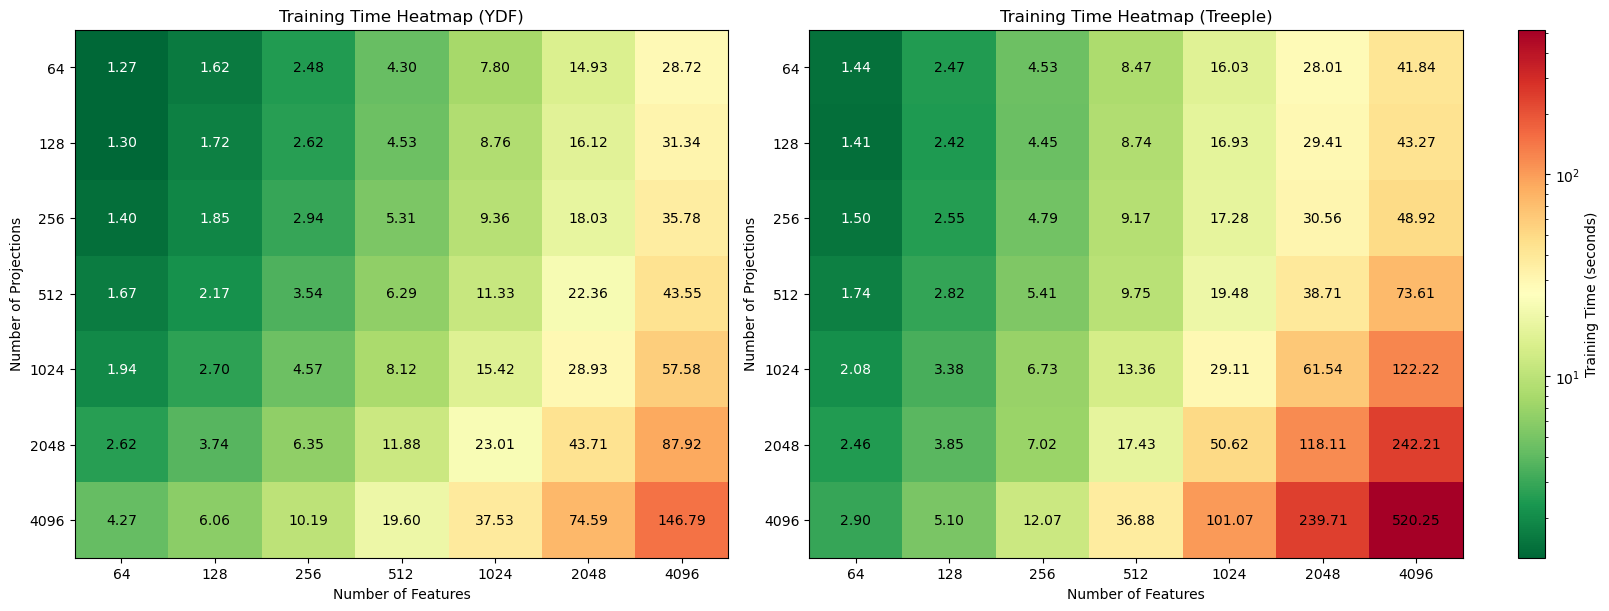

In [104]:

from matplotlib.colors import LogNorm

# Replace any 0 values to avoid log scale issues (if needed)
times_ydf1 = np.maximum(times_ydf, 1e-3)
times_treeple1 = np.maximum(times_treeple, 1e-3)

# Define shared log norm
log_norm = LogNorm(vmin=min(times_ydf1.min(), times_treeple1.min()),
                   vmax=max(times_ydf1.max(), times_treeple1.max()))

fig, axes = plt.subplots(1, 2, figsize=(16, 6), constrained_layout=True)

# Plot the heatmap for YDF
cax1 = axes[0].imshow(times_ydf1, cmap='RdYlGn_r', aspect='auto', norm=log_norm)
axes[0].set_title('Training Time Heatmap (YDF)')
axes[0].set_xlabel('Number of Features')
axes[0].set_ylabel('Number of Projections')
axes[0].set_xticks(np.arange(len(n_columns)))
axes[0].set_yticks(np.arange(len(n_rows)))
axes[0].set_xticklabels(n_columns)
axes[0].set_yticklabels(n_rows)

# Plot the heatmap for Treeple
cax2 = axes[1].imshow(times_treeple1, cmap='RdYlGn_r', aspect='auto', norm=log_norm)
axes[1].set_title('Training Time Heatmap (Treeple)')
axes[1].set_xlabel('Number of Features')
axes[1].set_ylabel('Number of Projections')
axes[1].set_xticks(np.arange(len(n_columns)))
axes[1].set_yticks(np.arange(len(n_rows)))
axes[1].set_xticklabels(n_columns)
axes[1].set_yticklabels(n_rows)

# Shared log-scaled colorbar
cbar = fig.colorbar(cax2, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Training Time (seconds)')

# Annotate each block for YDF
for i in range(len(n_rows)):
    for j in range(len(n_columns)):
        text_color = 'black' if log_norm(times_ydf1[i, j]) > 0.1 else 'white'
        axes[0].text(j, i, f"{times_ydf1[i, j]:.2f}", ha='center', va='center', color=text_color)

# Annotate each block for Treeple
for i in range(len(n_rows)):
    for j in range(len(n_columns)):
        text_color = 'black' if log_norm(times_treeple1[i, j]) > 0.1 else 'white'
        axes[1].text(j, i, f"{times_treeple1[i, j]:.2f}", ha='center', va='center', color=text_color)

plt.show()


In [105]:
# Save YDF running times to a text file
np.savetxt("result/times_ydf.txt", times_ydf, fmt="%.6f", header="YDF Running Times")

# Save Treeple running times to a text file
np.savetxt("result/times_treeple.txt", times_treeple, fmt="%.6f", header="Treeple Running Times")

### repeating third run with three n_reps

projection matrix shape: (64, 64)
Created projection matrix with the following parameters:
n_feature =  64 
n_samples =  2000 
max_features =  64 
feature_combinations =  64.0
max_features * feature_combinations =  4096.0
Number of non-zeros:  4096
-----------------------------------------
Constants: n_dim: 64 | n_tree: 200 | n_samples: 2000 | target_non_zeros: 4096 | n_rep: 3
Projection matrix: n_row: 64 | n_column: 64 | treeple_non_zeros: 4096
Feature combinations: 64.0 | max_features: 64
------------------------------------------
YDF parameters:
exponent: 2.0 | density_factor: 64.0 | max_num_projection: 64 | projection_density: 1.00
num of projections: 64 | expected non-zeros: 4096.00
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\treeple\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 64. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:01.171242
Train model on 1600 examples
Model trained in 0:00:01.133270
Train model on 1600 examples
Model trained in 0:00:01.123035
-----------------------------------------
Average nonzeros number in projection vectors among all nodes: 64.0
Average non-zeros per projection matrix: 4096.00
projection matrix shape: (128, 64)
Created projection matrix with the following parameters:
n_feature =  64 
n_samples =  2000 
max_features =  128 
feature_combinations =  32.0
max_features * feature_combinations =  4096.0
Number of non-zeros:  4096
-----------------------------------------
Constants: n_dim: 64 | n_tree: 200 | n_samples: 2000 | target_non_zeros: 4096 | n_rep: 3
Projection matrix: n_row: 128 | n_column: 64 | treeple_non_zeros: 4096
Feature combinations: 32.0 | max_features: 128
------------------------------------------
YDF parameters:
exponent: 1.8571428571428572 | density_factor: 32.0 | max_num_projection: 128 | projection_density: 0.50
num of projections: 128

c:\Users\clark\anaconda3\envs\treeple\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 128. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:01.256687
Train model on 1600 examples
Model trained in 0:00:01.235578
Train model on 1600 examples
Model trained in 0:00:01.226593
-----------------------------------------
Average nonzeros number in projection vectors among all nodes: 64.04396551724139
Average non-zeros per projection matrix: 4098.81
projection matrix shape: (128, 128)
Created projection matrix with the following parameters:
n_feature =  128 
n_samples =  2000 
max_features =  128 
feature_combinations =  32.0
max_features * feature_combinations =  4096.0
Number of non-zeros:  4096
-----------------------------------------
Constants: n_dim: 128 | n_tree: 200 | n_samples: 2000 | target_non_zeros: 4096 | n_rep: 3
Projection matrix: n_row: 128 | n_column: 128 | treeple_non_zeros: 4096
Feature combinations: 32.0 | max_features: 128
------------------------------------------
YDF parameters:
exponent: 2.0 | density_factor: 32.0 | max_num_projection: 128 | projection_density: 0.25
num of projections: 1

c:\Users\clark\anaconda3\envs\treeple\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 256. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:01.379025
Train model on 1600 examples
Model trained in 0:00:01.351770
Train model on 1600 examples
Model trained in 0:00:01.351130
-----------------------------------------
Average nonzeros number in projection vectors among all nodes: 64.07379310344828
Average non-zeros per projection matrix: 4100.72
projection matrix shape: (128, 256)
Created projection matrix with the following parameters:
n_feature =  256 
n_samples =  2000 
max_features =  128 
feature_combinations =  32.0
max_features * feature_combinations =  4096.0
Number of non-zeros:  4096
-----------------------------------------
Constants: n_dim: 256 | n_tree: 200 | n_samples: 2000 | target_non_zeros: 4096 | n_rep: 3
Projection matrix: n_row: 128 | n_column: 256 | treeple_non_zeros: 4096
Feature combinations: 32.0 | max_features: 128
------------------------------------------
YDF parameters:
exponent: 2.142857142857143 | density_factor: 32.0 | max_num_projection: 128 | projection_density: 0.12
num of 

c:\Users\clark\anaconda3\envs\treeple\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 512. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:01.560159
Train model on 1600 examples
Model trained in 0:00:01.556021
Train model on 1600 examples
Model trained in 0:00:01.561751
-----------------------------------------
Average nonzeros number in projection vectors among all nodes: 63.86568965517242
Average non-zeros per projection matrix: 4087.40
projection matrix shape: (128, 512)
Created projection matrix with the following parameters:
n_feature =  512 
n_samples =  2000 
max_features =  128 
feature_combinations =  32.0
max_features * feature_combinations =  4096.0
Number of non-zeros:  4096
-----------------------------------------
Constants: n_dim: 512 | n_tree: 200 | n_samples: 2000 | target_non_zeros: 4096 | n_rep: 3
Projection matrix: n_row: 128 | n_column: 512 | treeple_non_zeros: 4096
Feature combinations: 32.0 | max_features: 128
------------------------------------------
YDF parameters:
exponent: 2.2857142857142856 | density_factor: 32.0 | max_num_projection: 128 | projection_density: 0.06
num of

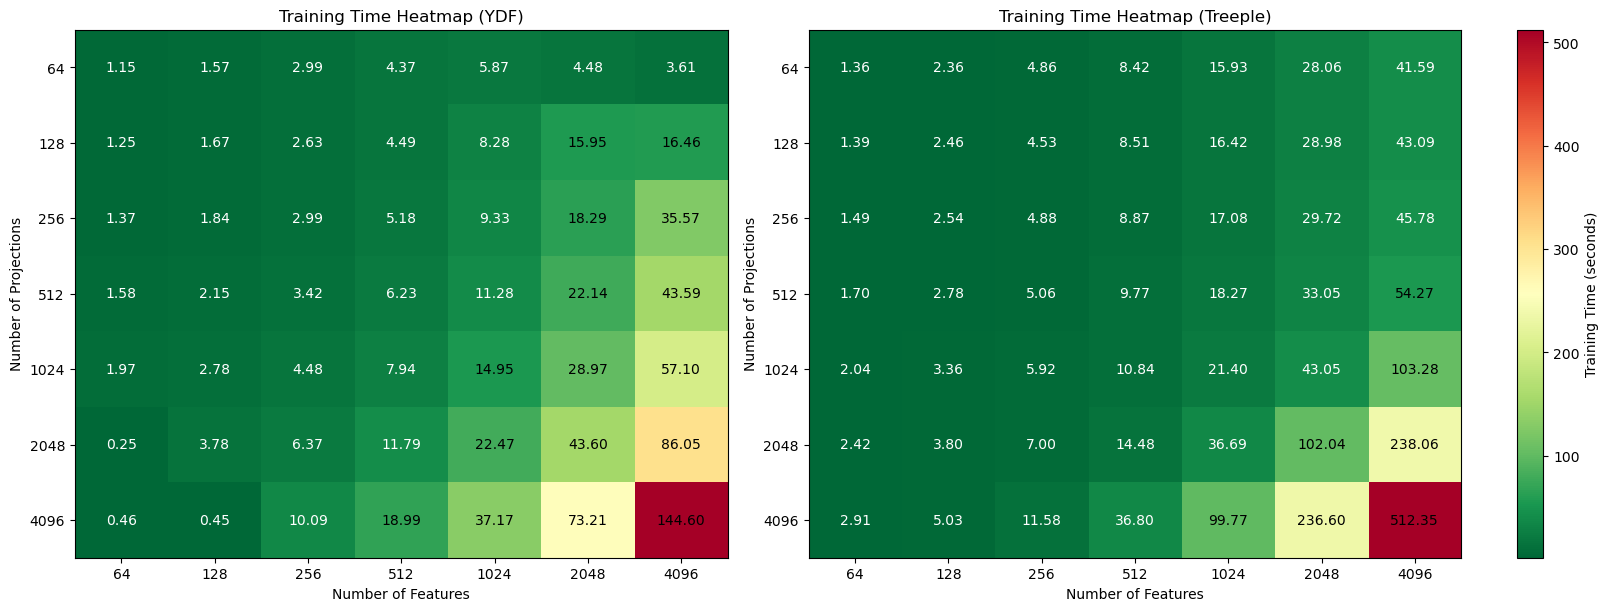

In [32]:
n_rows = np.ones(7)
n_rows[0] = 64
n_rows.shape
for i in range(0,n_rows.shape[0]-1):
    n_rows[i+1] = n_rows[i]*2
n_columns = n_rows

n_rows = n_rows.astype(int)
n_columns = n_columns.astype(int)
n_rows

accs_ydf, times_ydf, accs_treeple, times_treeple, f1_scores, params_ydf_check = constant_nNonzeros_simulation(
    n_tree=200, 
    params_treeple=params_treeple, 
    params_ydf=params_ydf,
    target_non_zeros=4096,  # Target number of non-zeros in the projection matrix
    n_rows=n_rows,          # Number of rows in the projection matrix
    n_columns=n_columns,    # Number of columns in the projection matrix
    n_samples=2000,         # Number of samples
    n_rep=3,                # Number of repetitions for averaging
    plot=False               # Whether to plot the projection matrix
)

## plopts
fig, axes = plt.subplots(1, 2, figsize=(16, 6), constrained_layout=True)

# Plot the heatmap for YDF
cax1 = axes[0].imshow(times_ydf, cmap='RdYlGn_r', aspect='auto')
axes[0].set_title('Training Time Heatmap (YDF)')
axes[0].set_xlabel('Number of Features')
axes[0].set_ylabel('Number of Projections')
axes[0].set_xticks(np.arange(len(n_columns)))
axes[0].set_yticks(np.arange(len(n_rows)))
axes[0].set_xticklabels(n_columns)
axes[0].set_yticklabels(n_rows)

# Plot the heatmap for Treeple
cax2 = axes[1].imshow(times_treeple, cmap='RdYlGn_r', aspect='auto')
axes[1].set_title('Training Time Heatmap (Treeple)')
axes[1].set_xlabel('Number of Features')
axes[1].set_ylabel('Number of Projections')
axes[1].set_xticks(np.arange(len(n_columns)))
axes[1].set_yticks(np.arange(len(n_rows)))
axes[1].set_xticklabels(n_columns)
axes[1].set_yticklabels(n_rows)

# Set shared color bar
cbar = fig.colorbar(cax2, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Training Time (seconds)')

# Annotate each block with the training time value for YDF
for i in range(len(n_rows)):
    for j in range(len(n_columns)):
        text_color = 'black' if cax1.norm(times_ydf[i, j]) > 0.1 else 'white'
        axes[0].text(j, i, f"{times_ydf[i, j]:.2f}", ha='center', va='center', color=text_color)

# Annotate each block with the training time value for Treeple
for i in range(len(n_rows)):
    for j in range(len(n_columns)):
        text_color = 'black' if cax2.norm(times_treeple[i, j]) > 0.1 else 'white'
        axes[1].text(j, i, f"{times_treeple[i, j]:.2f}", ha='center', va='center', color=text_color)

plt.show()

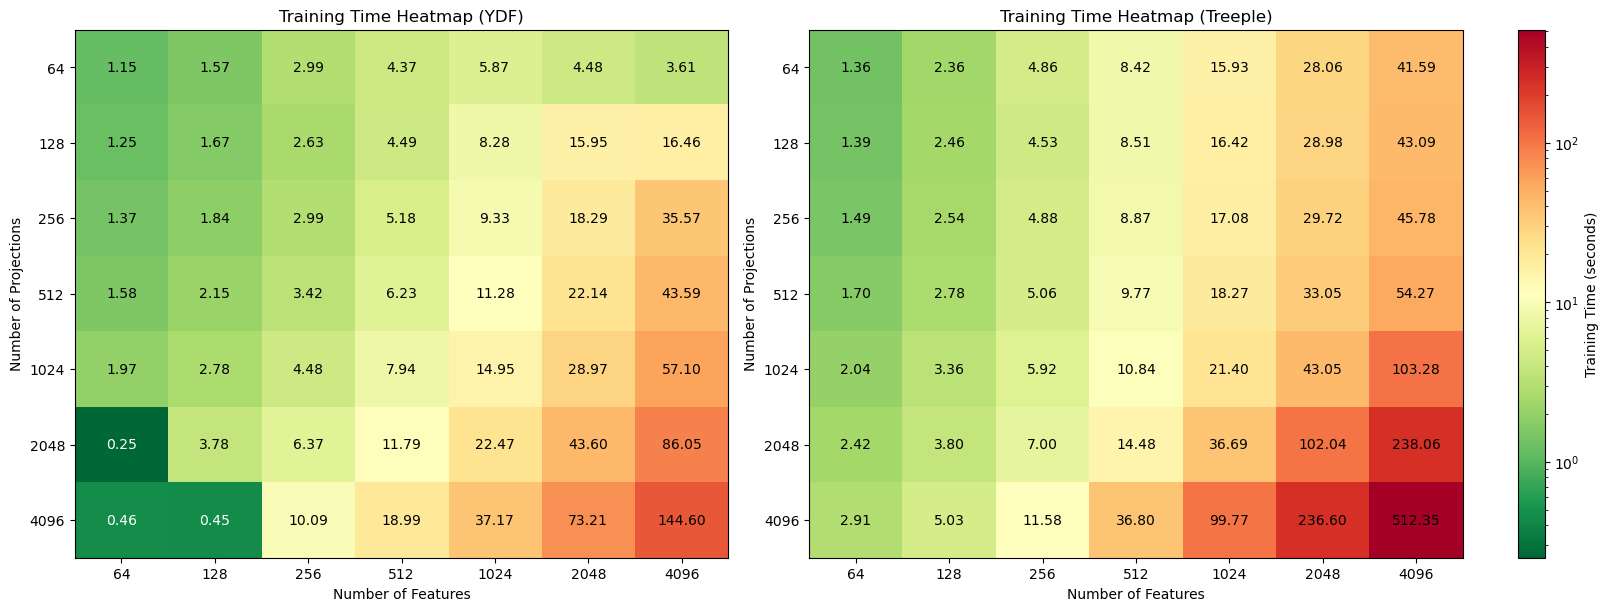

In [70]:

from matplotlib.colors import LogNorm

# Replace any 0 values to avoid log scale issues (if needed)
times_ydf1 = np.maximum(times_ydf, 1e-3)
times_treeple1 = np.maximum(times_treeple, 1e-3)

# Define shared log norm
log_norm = LogNorm(vmin=min(times_ydf1.min(), times_treeple1.min()),
                   vmax=max(times_ydf1.max(), times_treeple1.max()))

fig, axes = plt.subplots(1, 2, figsize=(16, 6), constrained_layout=True)

# Plot the heatmap for YDF
cax1 = axes[0].imshow(times_ydf1, cmap='RdYlGn_r', aspect='auto', norm=log_norm)
axes[0].set_title('Training Time Heatmap (YDF)')
axes[0].set_xlabel('Number of Features')
axes[0].set_ylabel('Number of Projections')
axes[0].set_xticks(np.arange(len(n_columns)))
axes[0].set_yticks(np.arange(len(n_rows)))
axes[0].set_xticklabels(n_columns)
axes[0].set_yticklabels(n_rows)

# Plot the heatmap for Treeple
cax2 = axes[1].imshow(times_treeple1, cmap='RdYlGn_r', aspect='auto', norm=log_norm)
axes[1].set_title('Training Time Heatmap (Treeple)')
axes[1].set_xlabel('Number of Features')
axes[1].set_ylabel('Number of Projections')
axes[1].set_xticks(np.arange(len(n_columns)))
axes[1].set_yticks(np.arange(len(n_rows)))
axes[1].set_xticklabels(n_columns)
axes[1].set_yticklabels(n_rows)

# Shared log-scaled colorbar
cbar = fig.colorbar(cax2, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Training Time (seconds)')

# Annotate each block for YDF
for i in range(len(n_rows)):
    for j in range(len(n_columns)):
        text_color = 'black' if log_norm(times_ydf1[i, j]) > 0.1 else 'white'
        axes[0].text(j, i, f"{times_ydf1[i, j]:.2f}", ha='center', va='center', color=text_color)

# Annotate each block for Treeple
for i in range(len(n_rows)):
    for j in range(len(n_columns)):
        text_color = 'black' if log_norm(times_treeple1[i, j]) > 0.1 else 'white'
        axes[1].text(j, i, f"{times_treeple1[i, j]:.2f}", ha='center', va='center', color=text_color)

plt.show()


In [89]:
treeple_params_list, ydf_params_list = get_params(
    n_tree=N_ESTIMATORS, 
    params_treeple=params_treeple, 
    params_ydf=params_ydf,
    target_non_zeros=4096,  # Target number of non-zeros in the projection matrix
    n_rows=n_rows,          # Number of rows in the projection matrix
    n_columns=n_columns,    # Number of columns in the projection matrix
    n_samples=2000         # Number of samples
)

projection matrix shape: (64, 64)
Created projection matrix with the following parameters:
n_feature =  64 
n_samples =  2000 
max_features =  64 
feature_combinations =  64.0
max_features * feature_combinations =  4096.0
Number of non-zeros:  4096
-----------------------------------------
Constants: n_dim: 64 | n_tree: 300 | n_samples: 2000 | target_non_zeros: 4096
Projection matrix: n_row: 64 | n_column: 64 | treeple_non_zeros: 4096
Feature combinations: 64.0 | max_features: 64
------------------------------------------
YDF parameters:
exponent: 1.0 | density_factor: 64.0 | max_num_projection: 64 | projection_density: 1.00
num of projections: 64 | expected non-zeros: 4096.00
projection matrix shape: (128, 64)
Created projection matrix with the following parameters:
n_feature =  64 
n_samples =  2000 
max_features =  128 
feature_combinations =  32.0
max_features * feature_combinations =  4096.0
Number of non-zeros:  4096
-----------------------------------------
Constants: n_dim: 64 

### Check treeple projection matrix

c:\Users\clark\anaconda3\envs\treeple\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 64. Setting n_informative to n_dim.
  warnings.warn(


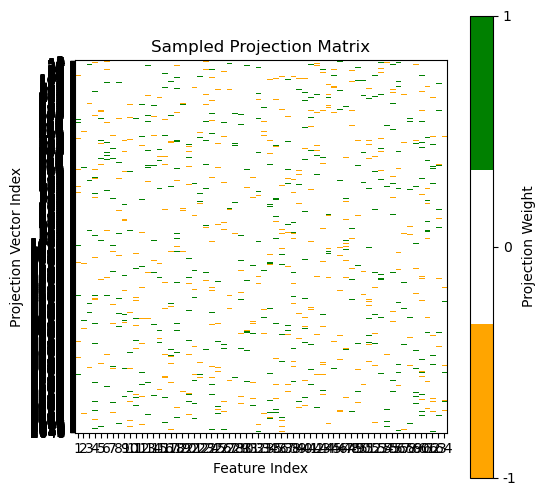

projection matrix shape: (2048, 64)
Created projection matrix with the following parameters:
n_feature =  64 
n_samples =  2000 
max_features =  2048 
feature_combinations =  2.0
max_features * feature_combinations =  4096.0
Number of non-zeros:  4096


In [71]:
def check_proj_matrix(i,j):
    X, y = make_trunk_classification(n_samples=2000, n_dim=n_rows[i], n_informative=600, seed=0)

    plot_proj_existing_data(X, y,
                    max_features=treeple_params_list[i,j]["max_features"], 
                    feature_combinations=treeple_params_list[i,j]["feature_combinations"],
                    plot_fig=True,
                    random_state=1)
check_proj_matrix(0,5)

c:\Users\clark\anaconda3\envs\treeple\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 64. Setting n_informative to n_dim.
  warnings.warn(


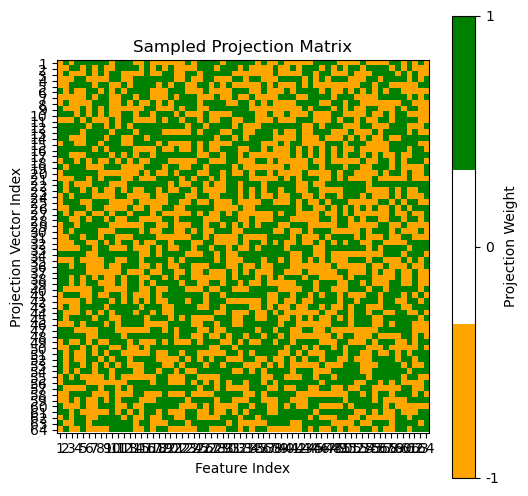

projection matrix shape: (64, 64)
Created projection matrix with the following parameters:
n_feature =  64 
n_samples =  2000 
max_features =  64 
feature_combinations =  64.0
max_features * feature_combinations =  4096.0
Number of non-zeros:  4096


In [73]:
check_proj_matrix(0,0)

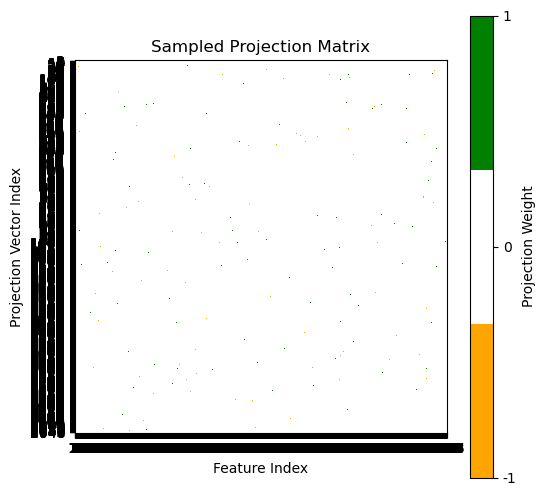

projection matrix shape: (2048, 2048)
Created projection matrix with the following parameters:
n_feature =  2048 
n_samples =  2000 
max_features =  2048 
feature_combinations =  2.0
max_features * feature_combinations =  4096.0
Number of non-zeros:  4096


In [74]:
check_proj_matrix(5,5)

In [78]:
n_rows

array([  64,  128,  256,  512, 1024, 2048, 4096])

### Check ydf model, use the algorithm from ydf to compute projection number and expected nonzero numbers

In [84]:
def check_ydf_model(i,j):
    
    print("------------------------------------------")
    print("YDF parameters:")
    exponent = ydf_params_list[i,j]["sparse_oblique_num_projections_exponent"]
    density_factor = ydf_params_list[i,j]["sparse_oblique_projection_density_factor"]

    num_projection = min(n_rows[j], int(math.ceil(n_columns[i]**exponent)+0.5))
    print(int(math.ceil(n_columns[i]**exponent)+0.5))
    projection_density = density_factor/ n_columns[i]
    ydf_nonzeros = num_projection * projection_density * n_columns[i]
    print(f"exponent: {exponent} | density_factor: {density_factor} | max_num_projection: {num_projection} | projection_density: {projection_density:.2f}")
    print(f"num of projections: {num_projection} | expected non-zeros: {ydf_nonzeros:.2f}")

print(n_columns[0], n_rows[5])
check_ydf_model(0,5)

64 2048
------------------------------------------
YDF parameters:
619
exponent: 1.5454545454545454 | density_factor: 2.0 | max_num_projection: 619 | projection_density: 0.03
num of projections: 619 | expected non-zeros: 1238.00


In [82]:
print(n_columns[0], n_rows[0])
check_ydf_model(0,0)

64 64
------------------------------------------
YDF parameters:
exponent: 2.0 | density_factor: 64.0 | max_num_projection: 64 | projection_density: 1.00
num of projections: 64 | expected non-zeros: 4096.00


## 1D, fixed projection num

In [106]:

n_rows = np.ones(7)
n_rows[0] = 64
n_rows.shape
for i in range(0,n_rows.shape[0]-1):
    n_rows[i+1] = n_rows[i]*2
n_columns = n_rows.astype(int)

n_rows = np.array([64])
n_rows = n_rows.astype(int)
#n_rows = np.array([128, 256, 512, 1024, 2048, 3072 ,4096])#, 5120, 6144, 7168 ,8192])



accs_ydf, times_ydf, accs_treeple, times_treeple, f1_scores, params_ydf_check = constant_nNonzeros_simulation(
    n_tree=200, 
    params_treeple=params_treeple, 
    params_ydf=params_ydf,
    target_non_zeros=4096,  # Target number of non-zeros in the projection matrix
    n_rows=n_rows,          # Number of rows in the projection matrix
    n_columns=n_columns,    # Number of columns in the projection matrix
    n_samples=2000,         # Number of samples
    n_rep=4,                # Number of repetitions for averaging
    plot=False               # Whether to plot the projection matrix
)

projection matrix shape: (64, 64)
Created projection matrix with the following parameters:
n_feature =  64 
n_samples =  2000 
max_features =  64 
feature_combinations =  64.0
max_features * feature_combinations =  4096.0
Number of non-zeros:  4096
-----------------------------------------
Constants: n_dim: 64 | n_tree: 200 | n_samples: 2000 | target_non_zeros: 4096 | n_rep: 4
Projection matrix: n_row: 64 | n_column: 64 | treeple_non_zeros: 4096
Feature combinations: 64.0 | max_features: 64
------------------------------------------
YDF parameters:
exponent: 1.0 | density_factor: 64.0 | max_num_projection: 64 | projection_density: 1.00
num of projections: 64 | expected non-zeros: 4096.00
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\treeple\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 64. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:01.195423
Train model on 1600 examples
Model trained in 0:00:01.141576
Train model on 1600 examples
Model trained in 0:00:01.211718
Train model on 1600 examples
Model trained in 0:00:01.160175
-----------------------------------------
Average nonzeros number in projection vectors among all nodes: 64.0
Average non-zeros per projection matrix: 4096.00
projection matrix shape: (64, 128)
Created projection matrix with the following parameters:
n_feature =  128 
n_samples =  2000 
max_features =  64 
feature_combinations =  64.0
max_features * feature_combinations =  4096.0
Number of non-zeros:  4096
-----------------------------------------
Constants: n_dim: 128 | n_tree: 200 | n_samples: 2000 | target_non_zeros: 4096 | n_rep: 4
Projection matrix: n_row: 64 | n_column: 128 | treeple_non_zeros: 4096
Feature combinations: 64.0 | max_features: 64
------------------------------------------
YDF parameters:
exponent: 0.8571428571428571 | density_factor: 64.0 | max_num_proje

c:\Users\clark\anaconda3\envs\treeple\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 128. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:01.370750
Train model on 1600 examples
Model trained in 0:00:01.336425
Train model on 1600 examples
Model trained in 0:00:01.369650
Train model on 1600 examples
Model trained in 0:00:01.390332
-----------------------------------------
Average nonzeros number in projection vectors among all nodes: 64.04396551724139
Average non-zeros per projection matrix: 4098.81
projection matrix shape: (64, 256)
Created projection matrix with the following parameters:
n_feature =  256 
n_samples =  2000 
max_features =  64 
feature_combinations =  64.0
max_features * feature_combinations =  4096.0
Number of non-zeros:  4096
-----------------------------------------
Constants: n_dim: 256 | n_tree: 200 | n_samples: 2000 | target_non_zeros: 4096 | n_rep: 4
Projection matrix: n_row: 64 | n_column: 256 | treeple_non_zeros: 4096
Feature combinations: 64.0 | max_features: 64
------------------------------------------
YDF parameters:
exponent: 0.75 | density_factor: 64.0 | max_num_projec

c:\Users\clark\anaconda3\envs\treeple\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 256. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:01.398870
Train model on 1600 examples
Model trained in 0:00:01.439720
Train model on 1600 examples
Model trained in 0:00:01.416214
Train model on 1600 examples
Model trained in 0:00:01.404288
-----------------------------------------
Average nonzeros number in projection vectors among all nodes: 64.07379310344828
Average non-zeros per projection matrix: 4100.72
projection matrix shape: (64, 512)
Created projection matrix with the following parameters:
n_feature =  512 
n_samples =  2000 
max_features =  64 
feature_combinations =  64.0
max_features * feature_combinations =  4096.0
Number of non-zeros:  4096
-----------------------------------------
Constants: n_dim: 512 | n_tree: 200 | n_samples: 2000 | target_non_zeros: 4096 | n_rep: 4
Projection matrix: n_row: 64 | n_column: 512 | treeple_non_zeros: 4096
Feature combinations: 64.0 | max_features: 64
------------------------------------------
YDF parameters:
exponent: 0.6666666666666666 | density_factor: 64.0 | 

c:\Users\clark\anaconda3\envs\treeple\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 512. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:01.818470
Train model on 1600 examples
Model trained in 0:00:01.819697
Train model on 1600 examples
Model trained in 0:00:01.687663
Train model on 1600 examples
Model trained in 0:00:01.581761
-----------------------------------------
Average nonzeros number in projection vectors among all nodes: 63.86568965517242
Average non-zeros per projection matrix: 4087.40
projection matrix shape: (64, 1024)
Created projection matrix with the following parameters:
n_feature =  1024 
n_samples =  2000 
max_features =  64 
feature_combinations =  64.0
max_features * feature_combinations =  4096.0
Number of non-zeros:  4096
-----------------------------------------
Constants: n_dim: 1024 | n_tree: 200 | n_samples: 2000 | target_non_zeros: 4096 | n_rep: 4
Projection matrix: n_row: 64 | n_column: 1024 | treeple_non_zeros: 4096
Feature combinations: 64.0 | max_features: 64
------------------------------------------
YDF parameters:
exponent: 0.6 | density_factor: 64.0 | max_num_pro

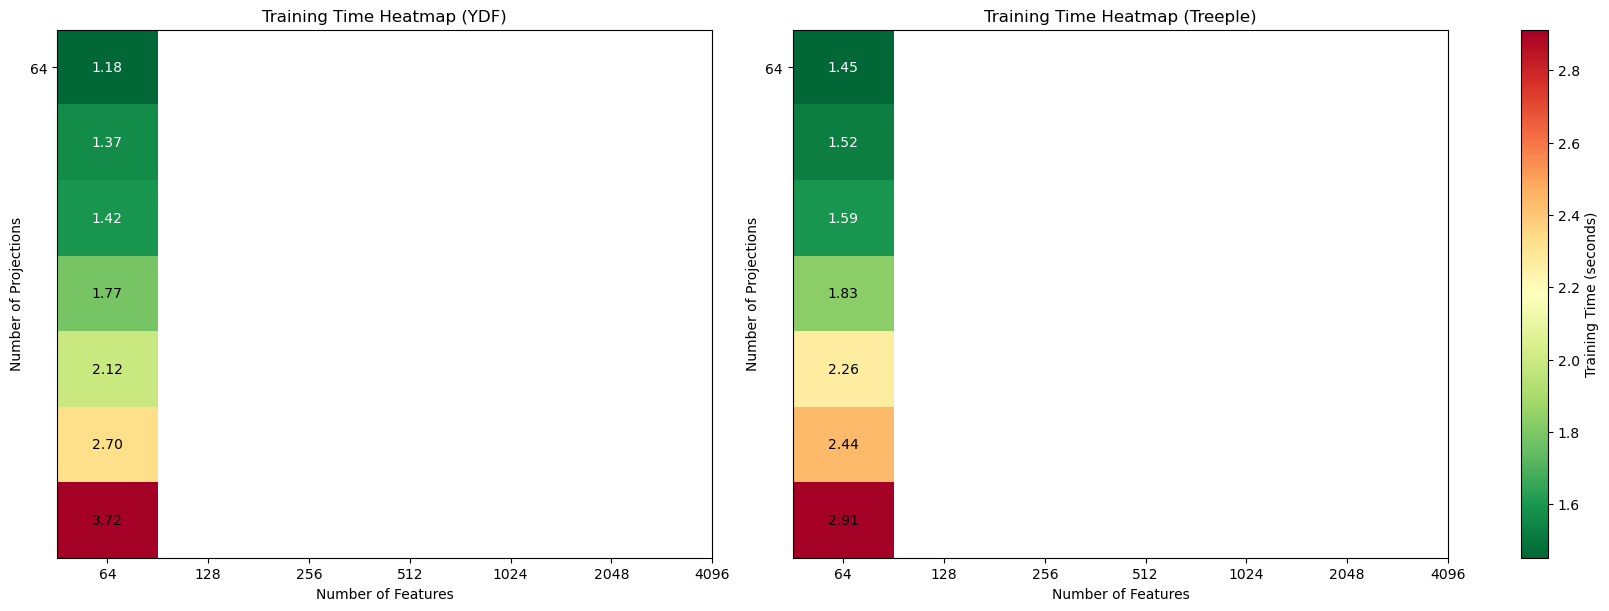

In [107]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), constrained_layout=True)

# Plot the heatmap for YDF
cax1 = axes[0].imshow(times_ydf, cmap='RdYlGn_r', aspect='auto')
axes[0].set_title('Training Time Heatmap (YDF)')
axes[0].set_xlabel('Number of Features')
axes[0].set_ylabel('Number of Projections')
axes[0].set_xticks(np.arange(len(n_columns)))
axes[0].set_yticks(np.arange(len(n_rows)))
axes[0].set_xticklabels(n_columns)
axes[0].set_yticklabels(n_rows)

# Plot the heatmap for Treeple
cax2 = axes[1].imshow(times_treeple, cmap='RdYlGn_r', aspect='auto')
axes[1].set_title('Training Time Heatmap (Treeple)')
axes[1].set_xlabel('Number of Features')
axes[1].set_ylabel('Number of Projections')
axes[1].set_xticks(np.arange(len(n_columns)))
axes[1].set_yticks(np.arange(len(n_rows)))
axes[1].set_xticklabels(n_columns)
axes[1].set_yticklabels(n_rows)

# Set shared color bar
cbar = fig.colorbar(cax2, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Training Time (seconds)')

# Annotate each block with the training time value for YDF
for i in range(len(n_columns)):
    for j in range(len(n_rows)):
        text_color = 'black' if cax1.norm(times_ydf[i, j]) > 0.1 else 'white'
        axes[0].text(j, i, f"{times_ydf[i, j]:.2f}", ha='center', va='center', color=text_color)

# Annotate each block with the training time value for Treeple
for i in range(len(n_columns)):
    for j in range(len(n_rows)):
        text_color = 'black' if cax2.norm(times_treeple[i, j]) > 0.1 else 'white'
        axes[1].text(j, i, f"{times_treeple[i, j]:.2f}", ha='center', va='center', color=text_color)

plt.show()

In [ ]:
results_treeple = np.loadtxt("result/times_treeple.txt")
results_ydf = np.loadtxt("result/times_ydf.txt")

array([1.265924, 1.295676, 1.3985  , 1.672967, 1.936928, 2.621412,
       4.269872])

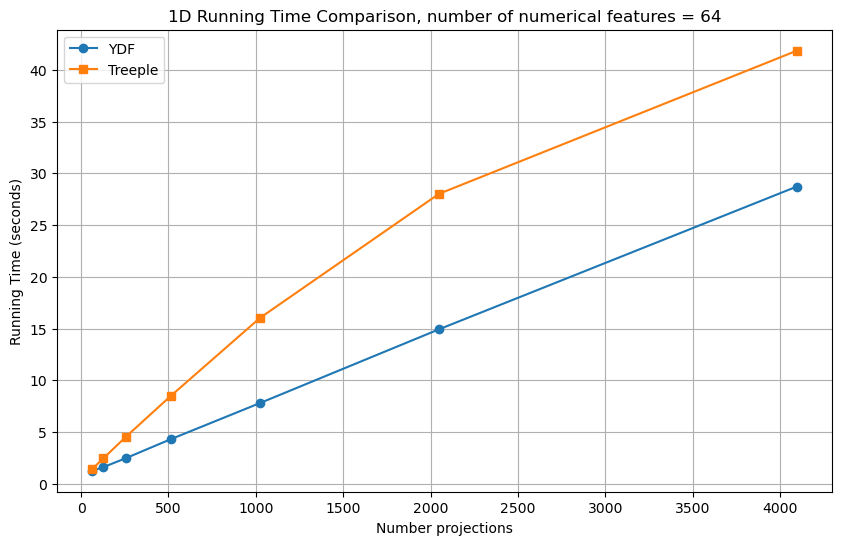

In [113]:
plt.figure(figsize=(10, 6))

# Plot YDF running times
plt.plot(n_columns, results_ydf[0,:].flatten(), label='YDF', marker='o')

# Plot Treeple running times
plt.plot(n_columns, results_treeple[0,:].flatten(), label='Treeple', marker='s')

# Add labels, title, and legend
plt.xlabel('Number projections')
plt.ylabel('Running Time (seconds)')
plt.title('1D Running Time Comparison, number of numerical features = 64')
plt.legend()
plt.grid(True)

plt.show()

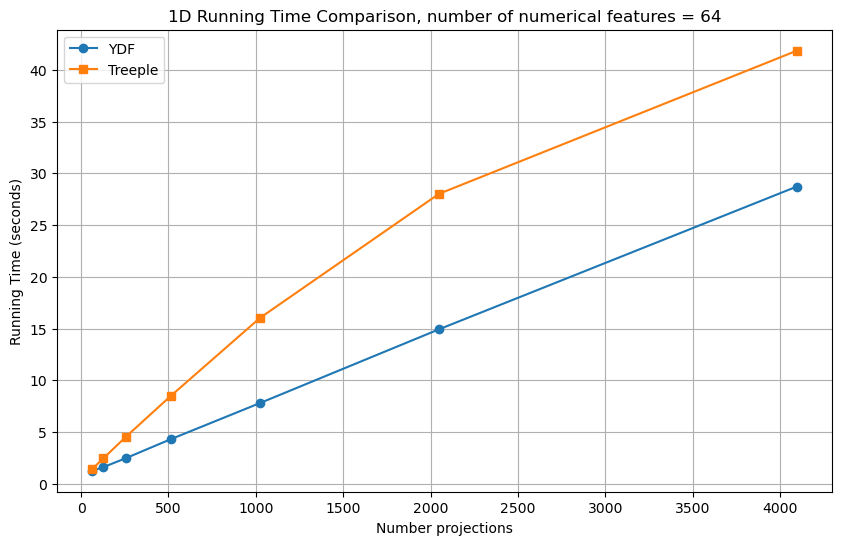

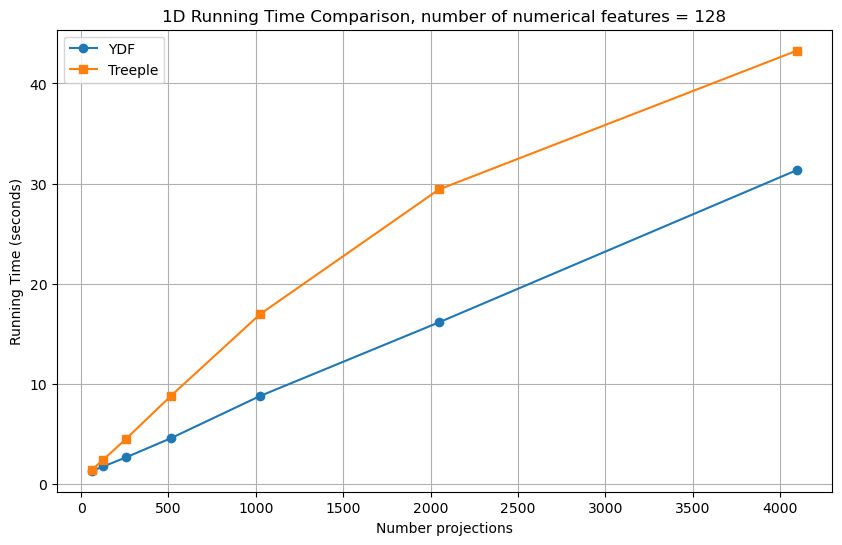

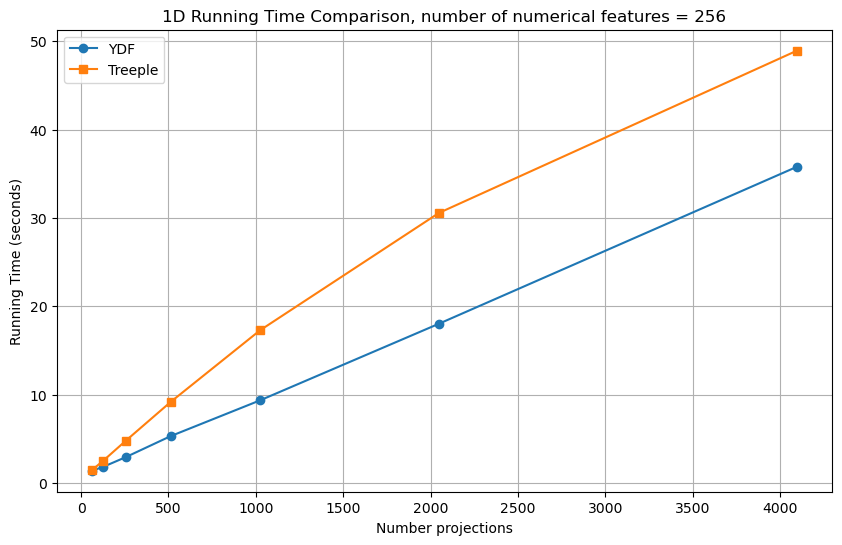

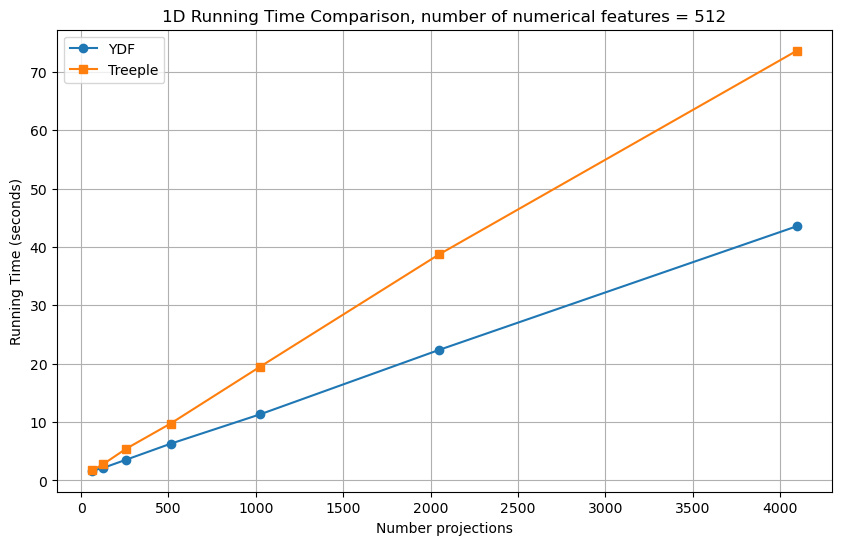

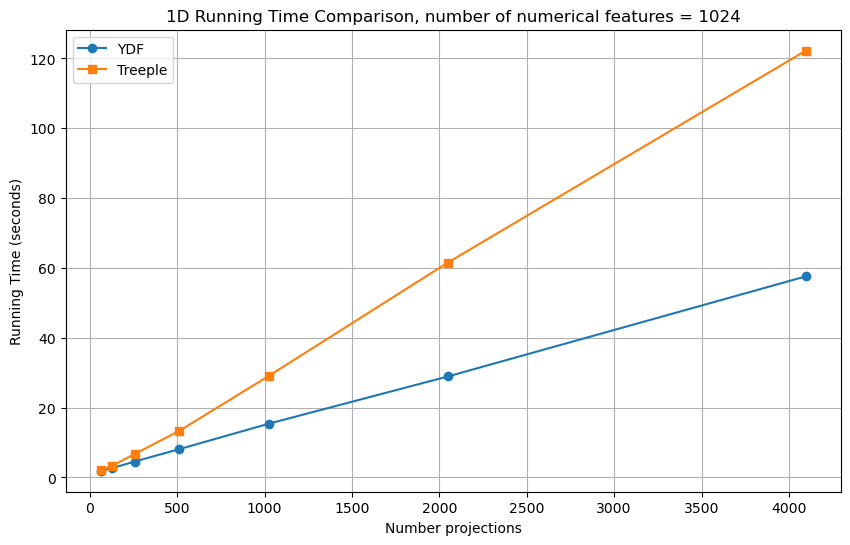

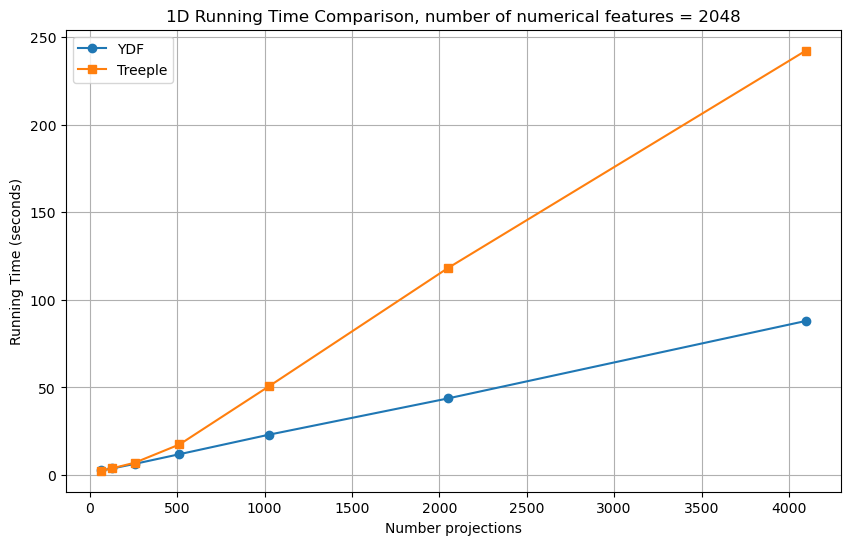

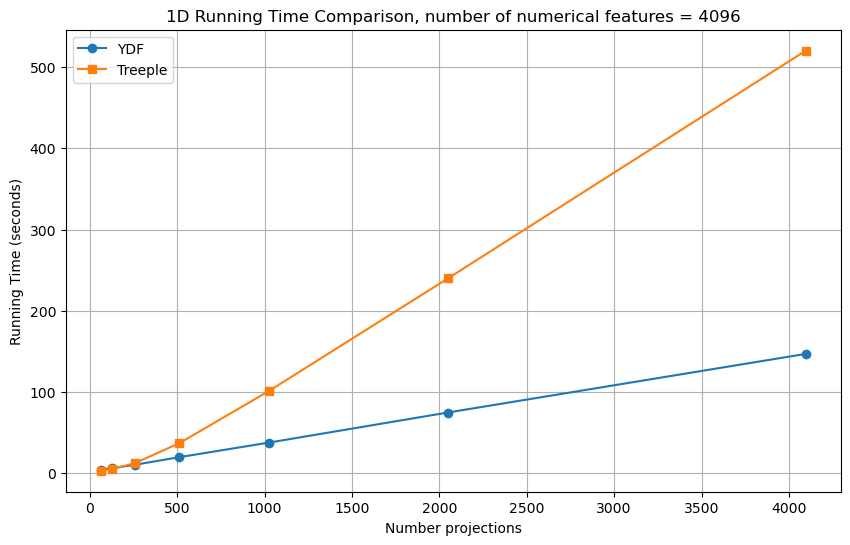

In [115]:
n_rows = np.array([64, 128, 256, 512, 1024, 2048, 4096])
for i, n_row in enumerate(n_rows):
    plt.figure(figsize=(10, 6))

    # Plot YDF running times
    plt.plot(n_columns, results_ydf[i,:].flatten(), label='YDF', marker='o')

    # Plot Treeple running times
    plt.plot(n_columns, results_treeple[i,:].flatten(), label='Treeple', marker='s')

    # Add labels, title, and legend
    plt.xlabel('Number projections')
    plt.ylabel('Running Time (seconds)')
    plt.title(f'1D Running Time Comparison, number of numerical features = {n_row}')
    plt.legend()
    plt.grid(True)

    plt.show()

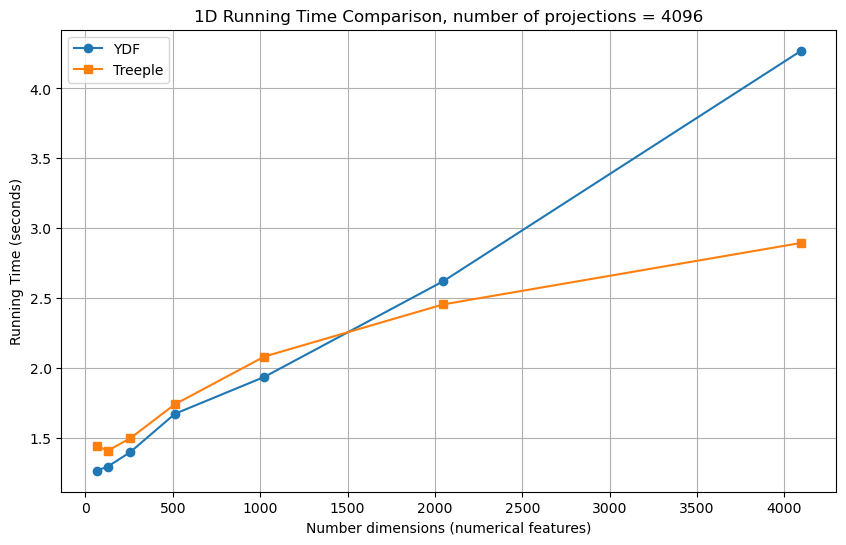

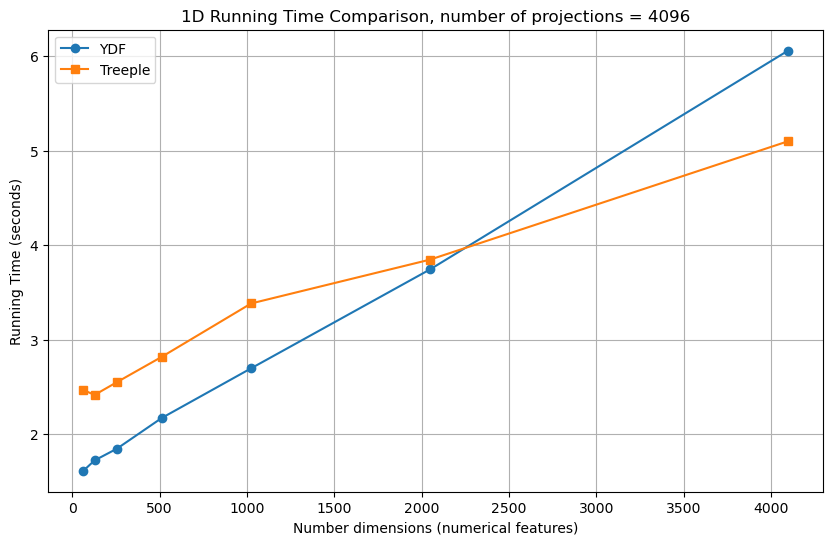

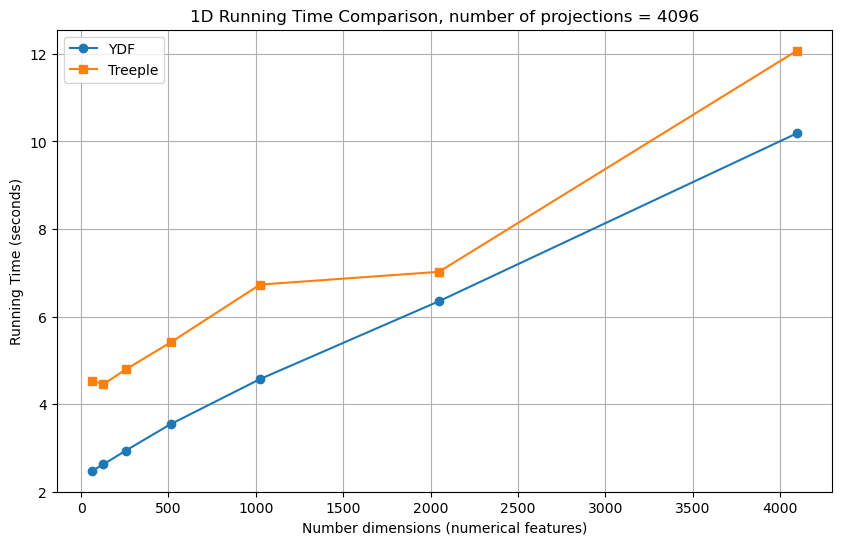

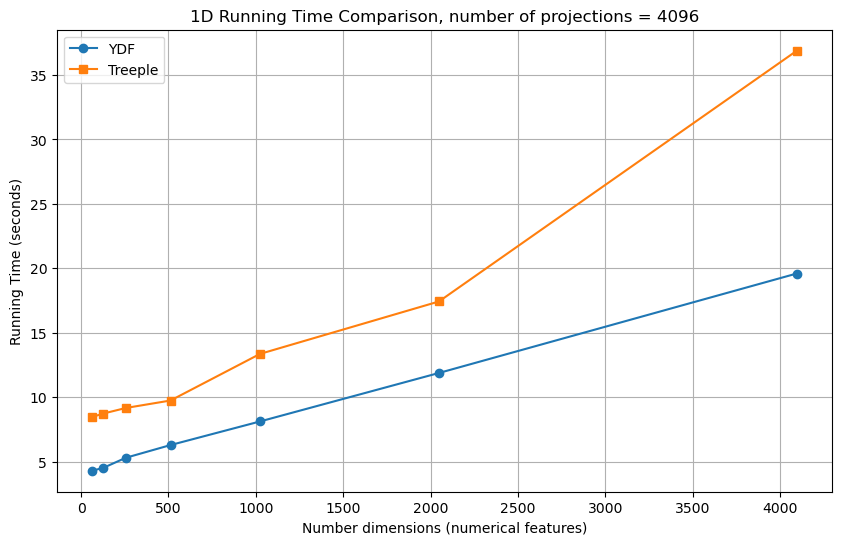

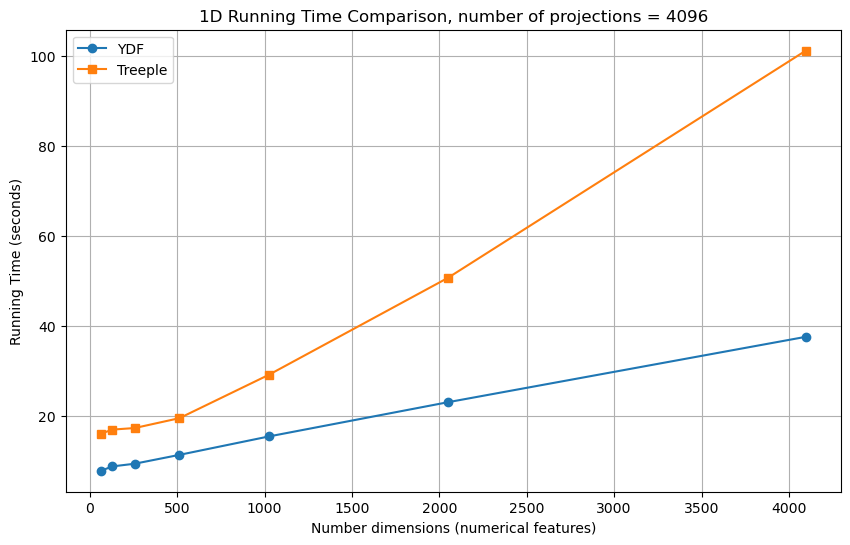

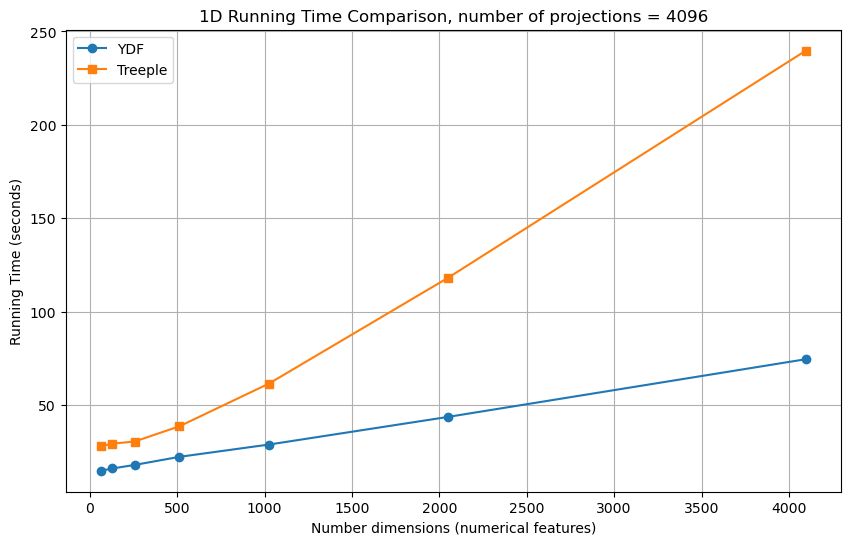

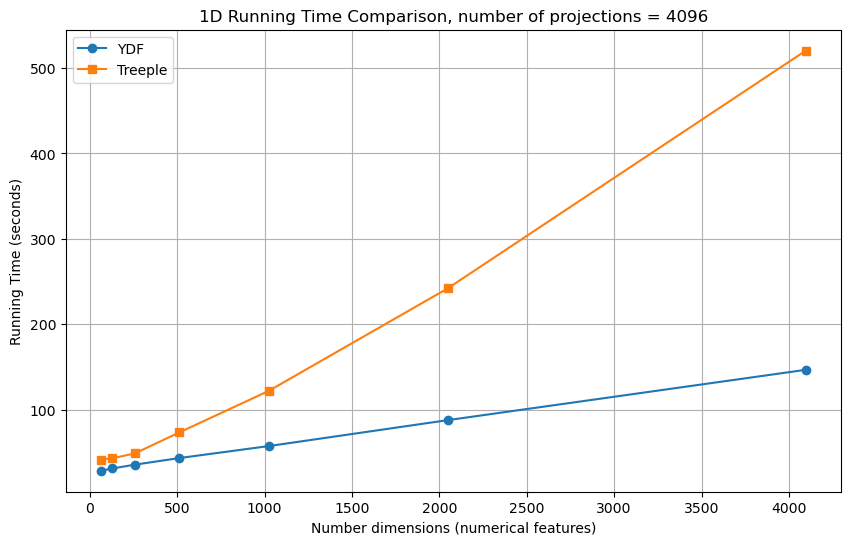

In [117]:
n_rows = np.array([64, 128, 256, 512, 1024, 2048, 4096])
for i, n_column in enumerate(n_columns):
    plt.figure(figsize=(10, 6))

    # Plot YDF running times
    plt.plot(n_rows, results_ydf[:,i].flatten(), label='YDF', marker='o')

    # Plot Treeple running times
    plt.plot(n_rows, results_treeple[:,i].flatten(), label='Treeple', marker='s')

    # Add labels, title, and legend
    plt.xlabel('Number dimensions (numerical features)')
    plt.ylabel('Running Time (seconds)')
    plt.title(f'1D Running Time Comparison, number of projections = {n_row}')
    plt.legend()
    plt.grid(True)

    plt.show()

# Trunk Simulation of result param sets

In [ ]:
def trunk_simulation(n_tree, num_dims, n_samples, params_treeple, params_ydf, n_rep=5, plot=True):
    accs_ydf = []
    times_ydf = []
    accs_treeple = []
    times_treeple = []
    f1_scores = []
    params_treeple1 = params_treeple.copy()  # Copy the original params for treeple
    params_ydf1 = params_ydf.copy()  # Copy the original params for ydf
    params_treeple1["n_estimators"] = n_tree
    params_ydf1["num_trees"] = n_tree
    

    for num_dim in num_dims:
        print(f"n_dim: {num_dim} | n_tree: {n_tree} | n_samples: {n_samples}")
        # projection_matrix_size = num_dim*params_treeple1['max_features']
        # print(f"projection_matrix_size: {projection_matrix_size}")
        # params_ydf1["sparse_oblique_max_num_projections"] = projection_matrix_size

        X, y = make_trunk_classification(n_samples=n_samples, n_dim=num_dim, n_informative=600, seed=0)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
        
        df_train = prepare_dataframe(X_train, y_train)
        df_test = prepare_dataframe(X_test, y_test)

        acc_temp_ydf=0
        time_temp_ydf=0

        acc_temp_treeple=0
        time_temp_treeple=0

        f1_temp=0

        for _ in range(n_rep):
            # --- Train YDF ---
            learner = ydf.RandomForestLearner(**params_ydf1)
            start_time = time.time()
            ydf_model = learner.train(df_train)
            time_ydf = time.time() - start_time
            pred_ydf = ydf_model.predict(df_test)
            pred_ydf = (pred_ydf >= 0.5).astype(int) 

            acc_ydf = accuracy_score(y_test, pred_ydf)
            acc_temp_ydf+=acc_ydf
            time_temp_ydf+=time_ydf
        
            # --- Train Treeple ---
            treeple_model = ObliqueRandomForestClassifier(**params_treeple1)
            acc_treeple, time_treeple, pred_treeple = train_treeple(treeple_model, "Treeple", X_train, X_test, y_train, y_test)
            acc_temp_treeple+=acc_treeple
            time_temp_treeple+=time_treeple

            # Calculate F1 score for two predictions
            f1_compare = f1_score(pred_ydf, pred_treeple)
            f1_temp+=f1_compare

        accs_ydf.append(acc_temp_ydf/n_rep)
        times_ydf.append(time_temp_ydf/n_rep)

        accs_treeple.append(acc_temp_treeple/n_rep)
        times_treeple.append(time_temp_treeple/n_rep)

        f1_scores.append(f1_temp/n_rep)
    if plot:
        plot_trunk_simulation(num_dims[:-1], accs_ydf[:-1], times_ydf[:-1], 
                                accs_treeple[:-1], times_treeple[:-1], f1_scores[:-1])
    return 1

def plot_trunk_simulation(num_dims, accs_ydf, times_ydf, accs_treeple, times_treeple, f1_scores):

    fig, ax1 = plt.subplots(1, 1, figsize=(5, 5))

    # Plot training time
    ax1.plot(num_dims, times_ydf, label='YDF Training Time', marker='o')
    ax1.plot(num_dims, times_treeple, label='Treeple Training Time', marker='o')
    ax1.set_xlabel('Number of Dimensions')
    ax1.set_ylabel('Training Time (seconds)')
    ax1.set_title('Training Time vs Number of Dimensions')
    ax1.legend()
    ax1.grid(True)


    plt.tight_layout()
    plt.show()

n_dim: 100 | n_tree: 200 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\treeple\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 100. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:02.579539
n_dim: 500 | n_tree: 200 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\treeple\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 500. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:03.431334
n_dim: 1000 | n_tree: 200 | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:04.388816
n_dim: 1500 | n_tree: 200 | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:05.251294
n_dim: 2000 | n_tree: 200 | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:06.615571
n_dim: 3000 | n_tree: 200 | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:08.031734
n_dim: 4000 | n_tree: 200 | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:09.824171


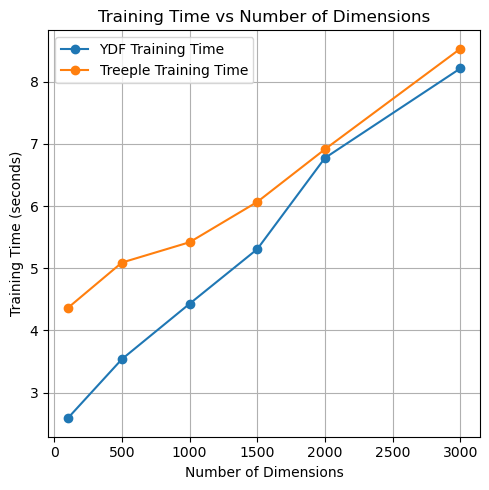

1

In [67]:
trunk_simulation(n_tree=200,
                 num_dims=[100, 500, 1000, 1500, 2000, 3000, 4000], 
                 n_samples=2000, 
                 params_treeple=treeple_params_list[0,2], 
                 params_ydf=ydf_params_list[0,2],
                 n_rep=1, 
                 plot=True)

In [ ]:
trunk_simulation(n_tree=200,
                 num_dims=[100, 500, 1000, 1500, 2000, 3000, 4000], 
                 n_samples=2000, 
                 params_treeple=treeple_params_list[0,2], 
                 params_ydf=ydf_params_list[0,2],
                 n_rep=1, 
                 plot=True)

# Look into tree objects. Max depth, n leaf, n nonleaf node, etc.

## YDF functions

In [148]:
def count_oblique_nodes(node):
    if isinstance(node, ydf.tree.Leaf):
        return 0

    count = 0
    if isinstance(node.condition, ydf.tree.NumericalSparseObliqueCondition):
        count += 1

    count += count_oblique_nodes(node.neg_child)
    count += count_oblique_nodes(node.pos_child)
    return count

def get_ydf_tree_info(root_node):
    if isinstance(root_node, ydf.tree.Leaf):
        return 1, 1, 0  # max_depth, num_nodes, num_oblique_nodes

    left_depth, left_nodes, left_oblique = get_ydf_tree_info(root_node.neg_child)
    right_depth, right_nodes, right_oblique = get_ydf_tree_info(root_node.pos_child)

    max_depth = 1 + max(left_depth, right_depth)
    total_nodes = 1 + left_nodes + right_nodes
    oblique_nodes = count_oblique_nodes(root_node) 
    leaf_nodes = total_nodes - oblique_nodes

    return max_depth, total_nodes, oblique_nodes


In [135]:
def get_ydf_model(params_ydf, n_sample=2000, n_estimator=100, n_dim=50, 
                    max_feature=100, feature_combination=3.0, exponent=1.0, X=None, y=None):
    if X is None or y is None:
        X, y = make_trunk_classification(n_samples=n_sample, n_dim=n_dim, n_informative=600, seed=0)
    X_train, _, y_train, _ = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    df_train = prepare_dataframe(X_train, y_train)

    params_ydf1 = params_ydf.copy()
    params_ydf1["num_trees"] = n_estimator
    params_ydf1["sparse_oblique_max_num_projections"] = max_feature
    params_ydf1["sparse_oblique_projection_density_factor"] = feature_combination
    params_ydf1["sparse_oblique_num_projections_exponent"] = exponent


    learner = ydf.RandomForestLearner(**params_ydf1)
    start_time = time.time()
    ydf_model = learner.train(df_train)
    time_taken = time.time() - start_time
    return ydf_model, time_taken

ydf_baby_param = ydf_params_list[0,0].copy()
ydf_baby_param["max_depth"] = 1
X, y = make_trunk_classification(n_samples=2000, n_dim=10, n_informative=600, seed=0)
# ydf
ydf_model, _ = get_ydf_model(ydf_baby_param, n_sample=2000, n_estimator=100, n_dim=10, 
                                max_feature=100, feature_combination=3.0, exponent=1.0)
ydf_estimator = ydf_model.get_tree(0)  # Get the root node of the first tree
get_ydf_tree_info(ydf_estimator.root)  # Get tree info for YDF model

Train model on 1600 examples
Model trained in 0:00:00.011530


c:\Users\clark\anaconda3\envs\treeple\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 10. Setting n_informative to n_dim.
  warnings.warn(


(2, 3, 1, 2)

## Treeple functions

In [140]:
def get_treeple_tree_info(treeple_estimator):
    max_depth = treeple_estimator.tree_.max_depth
    total_nodes = treeple_estimator.tree_.node_count
    leaf_nodes = treeple_estimator.tree_.n_leaves
    oblique_nodes = total_nodes - leaf_nodes
    return (max_depth, total_nodes, int(oblique_nodes), int(leaf_nodes))

def get_treeple_model(params_treeple, n_sample=2000, n_estimator=None, n_dim=50, 
                    max_feature=None, feature_combination=None, X=None, y=None):
    if X is None:
        X, y = make_trunk_classification(n_samples=n_sample, n_dim=n_dim, n_informative=600, seed=0)
    X_train, _, y_train, _ = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    params_treeple1 = params_treeple.copy()
    if max_feature is not None:
        params_treeple1["n_estimators"] = n_estimator
    if n_estimator is not None:
        params_treeple1["n_estimators"] = n_estimator
    if feature_combination is not None:
        params_treeple1["feature_combinations"] = feature_combination

    treeple_model = ObliqueRandomForestClassifier(**params_treeple1)
    treeple_model.fit(X_train, y_train)
    treeple_estimators = treeple_model.estimators_
    return treeple_estimators


In [141]:
treeple_baby_param = treeple_params_list[0,0].copy()
treeple_baby_param["max_depth"] = 1

treeple_estimators = get_treeple_model(treeple_baby_param, n_sample=2000, n_dim=64)
get_treeple_tree_info(treeple_estimators[0])

c:\Users\clark\anaconda3\envs\treeple\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 64. Setting n_informative to n_dim.
  warnings.warn(


(1, 3, 1, 2)

## modify the main experiment to also store the tree information

In [151]:
def constant_nNonzeros_simulation_new(n_tree,                   
                                params_treeple, 
                                params_ydf,
                                target_non_zeros,
                                n_rows,
                                n_columns,
                                n_samples=2000, 
                                n_rep=2,
                                plot=False):



    accs_ydf = np.zeros((len(n_columns), len(n_rows)))
    times_ydf = np.zeros(accs_ydf.shape)
    accs_treeple = np.zeros(accs_ydf.shape)
    times_treeple = np.zeros(accs_ydf.shape)
    f1_scores = np.zeros(accs_ydf.shape)
    ydf_estimator_info = np.empty((len(n_columns), len(n_rows)), dtype=object)
    treeple_estimator_info = np.empty((len(n_columns), len(n_rows)), dtype=object)
    

    # copy the params to avoid overwriting
    params_treeple1 = params_treeple.copy() 
    params_ydf1 = params_ydf.copy()
    params_ydf1["num_trees"] = n_tree
    params_treeple1["n_estimators"] = n_tree
    

    for i, n_column in enumerate(n_columns):
        # n_column matches number of features
        n_dim= n_column


        X, y = make_trunk_classification(n_samples=n_samples, n_dim=n_dim, n_informative=600, seed=0)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


        for j, n_row in enumerate(n_rows):
            # n_rows matches number of projections            
            feature_combination = target_non_zeros / n_row
            params_treeple1["max_features"] = n_row
            params_treeple1["feature_combinations"] = feature_combination
            
            params_ydf1["sparse_oblique_max_num_projections"] = int(n_row)
            params_ydf1["sparse_oblique_projection_density_factor"] = feature_combination
            #params_ydf1["sparse_oblique_num_projections_exponent"] = math.log(n_column, n_row) + 1.0
            params_ydf1["sparse_oblique_num_projections_exponent"] = math.log(n_row, n_column)

            # see if matches the target non-zeros
            _, treeple_n_nonzeros = plot_proj_existing_data(X, y,
                max_features=n_row, 
                feature_combinations=feature_combination,
                plot_fig=False,
                random_state=1)

            print("-----------------------------------------")        
            print(f"Constants: n_dim: {n_dim} | n_tree: {n_tree} | n_samples: {n_samples} | target_non_zeros: {target_non_zeros} | n_rep: {n_rep}")
            print(f"Projection matrix: n_row: {n_row} | n_column: {n_column} | treeple_non_zeros: {treeple_n_nonzeros}")
            print(f"Feature combinations: {feature_combination} | max_features: {n_row}")


            print("------------------------------------------")
            print("YDF parameters:")
            exponent = params_ydf1["sparse_oblique_num_projections_exponent"]
            density_factor = params_ydf1["sparse_oblique_projection_density_factor"]

            num_projection = min(n_row, int(math.ceil(n_column**exponent)+0.5))
            projection_density = density_factor/ n_column
            ydf_nonzeros = num_projection * projection_density * n_column
            print(f"exponent: {exponent} | density_factor: {density_factor} | max_num_projection: {num_projection} | projection_density: {projection_density:.2f}")
            print(f"num of projections: {num_projection} | expected non-zeros: {ydf_nonzeros:.2f}")
            
            acc_temp_ydf=0
            time_temp_ydf=0

            acc_temp_treeple=0
            time_temp_treeple=0

            f1_temp=0

            for _ in range(n_rep):
                # --- Train YDF ---
                acc_ydf, time_ydf, pred_ydf, ydf_model = train_ydf(X_train, y_train, X_test, y_test, params_ydf1)
                acc_temp_ydf+=acc_ydf
                time_temp_ydf+=time_ydf
            
                # --- Train Treeple ---
                treeple_model = ObliqueRandomForestClassifier(**params_treeple1)
                start_time = time.time()
                treeple_model.fit(X_train, y_train)
                time_treeple = time.time() - start_time

                pred_treeple = treeple_model.predict(X_test)
                if isinstance(pred_treeple[0], np.ndarray):  # Some models return probabilities
                    pred_treeple = np.argmax(pred_treeple, axis=1)

                acc_treeple = accuracy_score(y_test, pred_treeple)
                acc_temp_treeple+=acc_treeple
                time_temp_treeple+=time_treeple

                # Calculate F1 score for two predictions
                f1_compare = f1_score(pred_ydf, pred_treeple)
                f1_temp+=f1_compare
            
            ##### store estimator results #####
            treeple_estimator_info[i,j] = get_treeple_tree_info(treeple_model.estimators_[0])
            max_depth, total_nodes, oblique_nodes = get_ydf_tree_info(ydf_model.get_tree(0).root)
            ydf_estimator_info[i,j] = (max_depth, total_nodes, oblique_nodes, total_nodes-oblique_nodes)

            # check average number of non-zeros per vector
            print("-----------------------------------------")
            _,_,_,avg_non_zeros = extract_avg_projection(ydf_model, n_tree, n_dim)
            print(f"Average non-zeros per projection matrix: {avg_non_zeros*n_row:.2f}")


            # Store results
            accs_ydf[i,j] = acc_temp_ydf/n_rep
            times_ydf[i,j] = time_temp_ydf/n_rep

            accs_treeple[i,j] = acc_temp_treeple/n_rep
            times_treeple[i,j] = time_temp_treeple/n_rep

            f1_scores[i,j] = f1_temp/n_rep

    return accs_ydf, times_ydf, accs_treeple, times_treeple, f1_scores, treeple_estimator_info, ydf_estimator_info

## Run the new simulation, visualize estimator info

In [175]:
n_rows = np.array([64, 128, 256, 512, 1024, 2048])
n_columns = n_rows.copy()

In [179]:
params_treeple

{'n_estimators': 300,
 'criterion': 'entropy',
 'max_depth': 10,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'min_weight_fraction_leaf': 0.0,
 'max_features': 100,
 'max_leaf_nodes': 30,
 'min_impurity_decrease': 0.0,
 'bootstrap': True,
 'oob_score': False,
 'n_jobs': -1,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False,
 'class_weight': None,
 'max_samples': None,
 'feature_combinations': 3.0}

In [180]:
params_ydf

{'label': 'target',
 'max_depth': 10,
 'num_trees': 300,
 'random_seed': 42,
 'honest': False,
 'bootstrap_size_ratio': 1.0,
 'bootstrap_training_dataset': True,
 'categorical_algorithm': 'ONE_HOT',
 'compute_oob_performances': False,
 'compute_oob_variable_importances': False,
 'in_split_min_examples_check': True,
 'min_examples': 1,
 'keep_non_leaf_label_distribution': True,
 'max_num_nodes': 30,
 'growing_strategy': 'BEST_FIRST_GLOBAL',
 'num_candidate_attributes_ratio': 1.0,
 'sorting_strategy': 'IN_NODE',
 'split_axis': 'SPARSE_OBLIQUE',
 'sparse_oblique_weights': 'BINARY',
 'sparse_oblique_projection_density_factor': 3.0,
 'sparse_oblique_normalization': 'MIN_MAX',
 'sparse_oblique_max_num_projections': 100,
 'sparse_oblique_num_projections_exponent': 1.0,
 'sampling_with_replacement': False}

In [ ]:


_,_,_,_,_,treeple_estimator_info, ydf_estimator_info = constant_nNonzeros_simulation_new(200,                   
                                params_treeple, 
                                params_ydf,
                                2048,
                                n_rows,
                                n_columns,
                                n_samples=2000, 
                                n_rep=1,
                                plot=False)

projection matrix shape: (64, 64)
Created projection matrix with the following parameters:
n_feature =  64 
n_samples =  2000 
max_features =  64 
feature_combinations =  32.0
max_features * feature_combinations =  2048.0
Number of non-zeros:  2048
-----------------------------------------
Constants: n_dim: 64 | n_tree: 200 | n_samples: 2000 | target_non_zeros: 2048 | n_rep: 1
Projection matrix: n_row: 64 | n_column: 64 | treeple_non_zeros: 2048
Feature combinations: 32.0 | max_features: 64
------------------------------------------
YDF parameters:
exponent: 1.0 | density_factor: 32.0 | max_num_projection: 64 | projection_density: 0.50
num of projections: 64 | expected non-zeros: 2048.00
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\treeple\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 64. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.826492
-----------------------------------------
Average nonzeros number in projection vectors among all nodes: 31.986034482758622
Average non-zeros per projection matrix: 2047.11
projection matrix shape: (128, 64)
Created projection matrix with the following parameters:
n_feature =  64 
n_samples =  2000 
max_features =  128 
feature_combinations =  16.0
max_features * feature_combinations =  2048.0
Number of non-zeros:  2048
-----------------------------------------
Constants: n_dim: 64 | n_tree: 200 | n_samples: 2000 | target_non_zeros: 2048 | n_rep: 1
Projection matrix: n_row: 128 | n_column: 64 | treeple_non_zeros: 2048
Feature combinations: 16.0 | max_features: 128
------------------------------------------
YDF parameters:
exponent: 1.1666666666666667 | density_factor: 16.0 | max_num_projection: 128 | projection_density: 0.25
num of projections: 128 | expected non-zeros: 2048.00
Train model on 1600 examples
Model trained in 0:00:01.255537
----------------

c:\Users\clark\anaconda3\envs\treeple\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 128. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.872717
-----------------------------------------
Average nonzeros number in projection vectors among all nodes: 31.823103448275862
Average non-zeros per projection matrix: 2036.68
projection matrix shape: (128, 128)
Created projection matrix with the following parameters:
n_feature =  128 
n_samples =  2000 
max_features =  128 
feature_combinations =  16.0
max_features * feature_combinations =  2048.0
Number of non-zeros:  2048
-----------------------------------------
Constants: n_dim: 128 | n_tree: 200 | n_samples: 2000 | target_non_zeros: 2048 | n_rep: 1
Projection matrix: n_row: 128 | n_column: 128 | treeple_non_zeros: 2048
Feature combinations: 16.0 | max_features: 128
------------------------------------------
YDF parameters:
exponent: 1.0 | density_factor: 16.0 | max_num_projection: 128 | projection_density: 0.12
num of projections: 128 | expected non-zeros: 2048.00
Train model on 1600 examples
Model trained in 0:00:01.335265
---------------------------

c:\Users\clark\anaconda3\envs\treeple\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 256. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.953198
-----------------------------------------
Average nonzeros number in projection vectors among all nodes: 31.92706896551724
Average non-zeros per projection matrix: 2043.33
projection matrix shape: (128, 256)
Created projection matrix with the following parameters:
n_feature =  256 
n_samples =  2000 
max_features =  128 
feature_combinations =  16.0
max_features * feature_combinations =  2048.0
Number of non-zeros:  2048
-----------------------------------------
Constants: n_dim: 256 | n_tree: 200 | n_samples: 2000 | target_non_zeros: 2048 | n_rep: 1
Projection matrix: n_row: 128 | n_column: 256 | treeple_non_zeros: 2048
Feature combinations: 16.0 | max_features: 128
------------------------------------------
YDF parameters:
exponent: 0.875 | density_factor: 16.0 | max_num_projection: 128 | projection_density: 0.06
num of projections: 128 | expected non-zeros: 2048.00
Train model on 1600 examples
Model trained in 0:00:01.503641
--------------------------

c:\Users\clark\anaconda3\envs\treeple\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 512. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:01.114349
-----------------------------------------
Average nonzeros number in projection vectors among all nodes: 31.968620689655175
Average non-zeros per projection matrix: 2045.99
projection matrix shape: (128, 512)
Created projection matrix with the following parameters:
n_feature =  512 
n_samples =  2000 
max_features =  128 
feature_combinations =  16.0
max_features * feature_combinations =  2048.0
Number of non-zeros:  2048
-----------------------------------------
Constants: n_dim: 512 | n_tree: 200 | n_samples: 2000 | target_non_zeros: 2048 | n_rep: 1
Projection matrix: n_row: 128 | n_column: 512 | treeple_non_zeros: 2048
Feature combinations: 16.0 | max_features: 128
------------------------------------------
YDF parameters:
exponent: 0.7777777777777778 | density_factor: 16.0 | max_num_projection: 128 | projection_density: 0.03
num of projections: 128 | expected non-zeros: 2048.00
Train model on 1600 examples
Model trained in 0:00:01.760726
------------

info stored in this order:

(max_depth, total_nodes, int(oblique_nodes), int(leaf_nodes))

In [163]:
# Extract the number of leaves from treeple_estimator_info
num_leaves_treeple = np.array([[info[3] for info in row] for row in treeple_estimator_info])
num_leaves_ydf = np.array([[info[3] for info in row] for row in ydf_estimator_info])

num_noded_treeple = np.array([[info[2] for info in row] for row in treeple_estimator_info])
num_noded_ydf = np.array([[info[2] for info in row] for row in ydf_estimator_info])

max_dept_treeple = np.array([[info[0] for info in row] for row in treeple_estimator_info])
max_dept_ydf = np.array([[info[0] for info in row] for row in ydf_estimator_info])

print("Treeple number of leaves:")
print(num_leaves_treeple)
print("YDF number of leaves:")
print(num_leaves_ydf)
print("-----------------------------")
print("Treeple number of nodes:")
print(num_noded_treeple)
print("YDF number of nodes:")
print(num_noded_ydf)
print("-----------------------------")
print("Treeple max depth:")
print(max_dept_treeple)
print("YDF max depth:")
print(max_dept_ydf)

Treeple number of leaves:
[[30 30 30 30 30 30]
 [30 30 30 30 30 30]
 [30 30 30 30 30 30]
 [30 30 30 30 30 30]
 [30 30 30 30 30 30]
 [30 30 30 30 30 30]]
YDF number of leaves:
[[30 30 30 30 30 30]
 [30 30 30 30 30 30]
 [30 30 30 30 30 30]
 [30 30 30 30 30 30]
 [30 30 30 30 30 30]
 [30 30 30 30 30 30]]
-----------------------------
Treeple number of nodes:
[[29 29 29 29 29 29]
 [29 29 29 29 29 29]
 [29 29 29 29 29 29]
 [29 29 29 29 29 29]
 [29 29 29 29 29 29]
 [29 29 29 29 29 29]]
YDF number of nodes:
[[29 29 29 29 29 29]
 [29 29 29 29 29 29]
 [29 29 29 29 29 29]
 [29 29 29 29 29 29]
 [29 29 29 29 29 29]
 [29 29 29 29 29 29]]
-----------------------------
Treeple max depth:
[[ 8  8  9  7  9  9]
 [ 8  8 10  7  8 10]
 [ 8  7  8  7  8  7]
 [ 7  9  9 10  7 10]
 [10 10  9  8  7  8]
 [ 8 10  9 10  9  9]]
YDF max depth:
[[ 8  9  8  8  9  9]
 [ 8  8 10  8 10 10]
 [10  9  9  9  8 10]
 [11 10  8 10  8 10]
 [11  9 11 10 11  9]
 [10 11 11  8  9  9]]


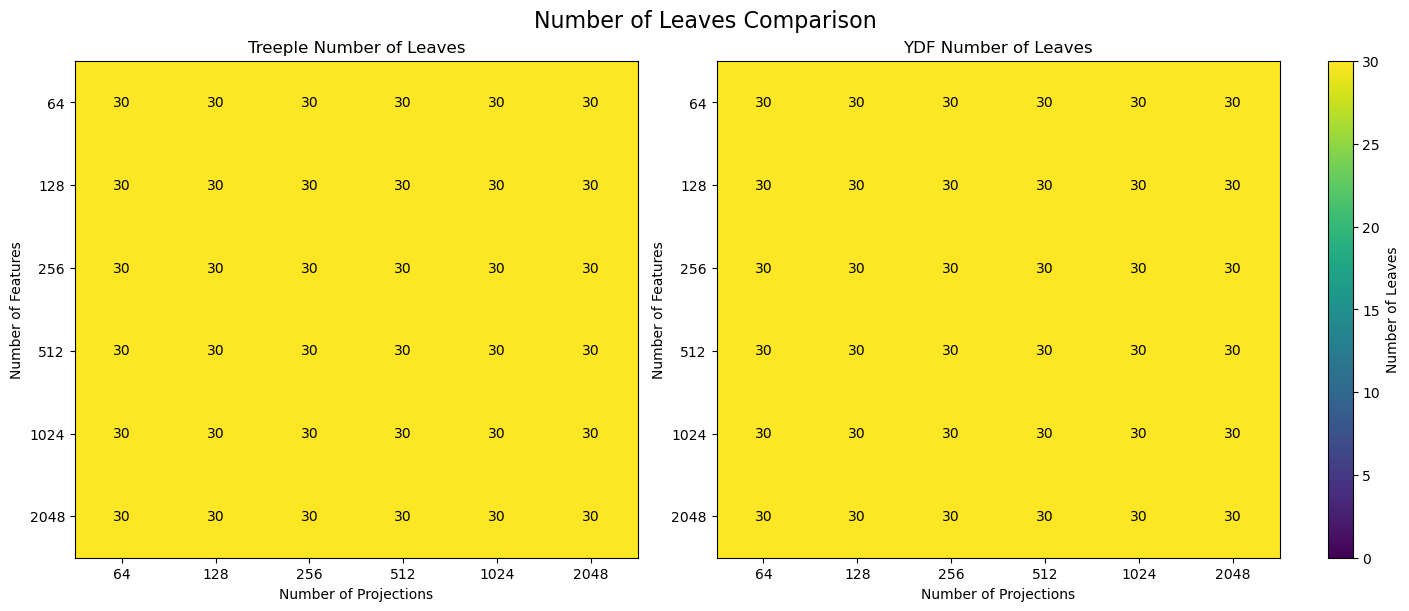

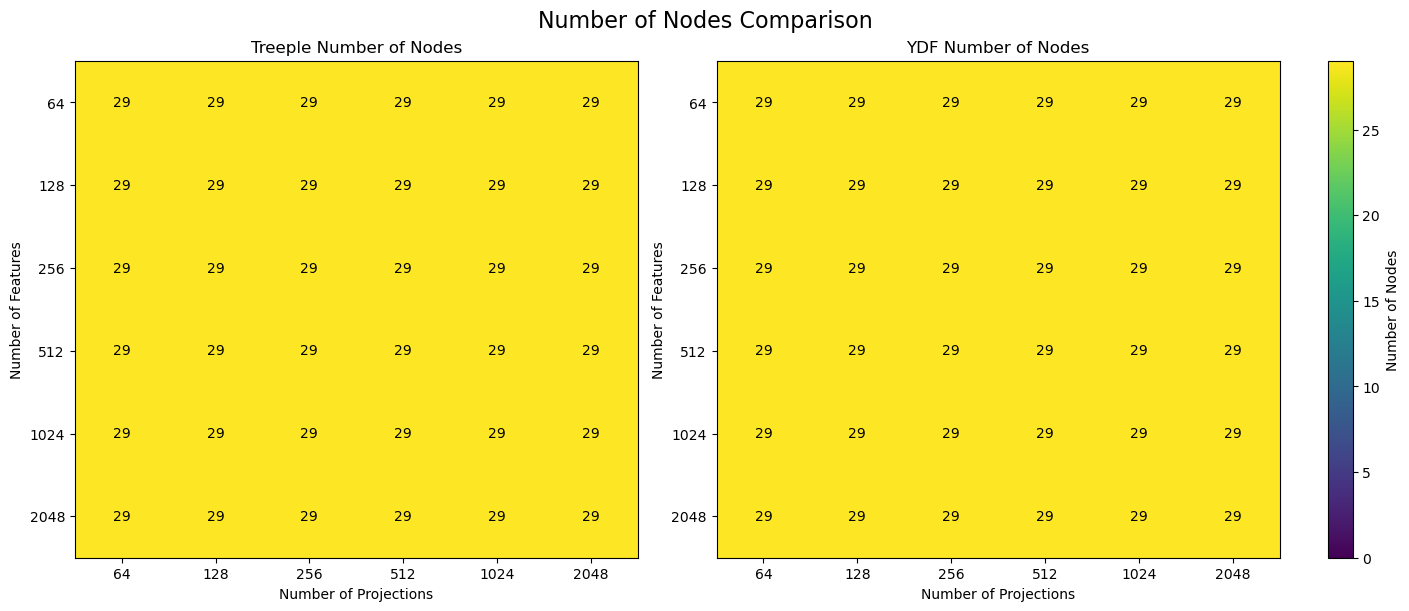

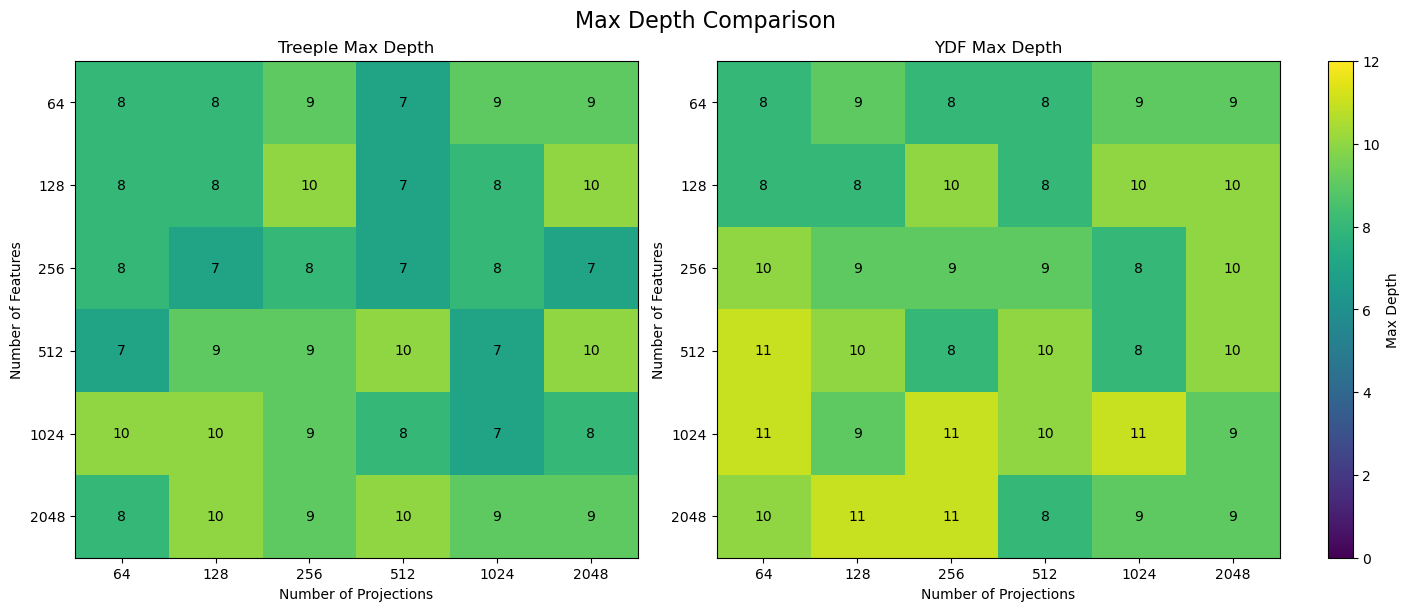

In [177]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

# Example tick values (replace with your actual lists)
# n_columns = [10, 20, 30, 40, 50]  # Number of features (y-axis)
# n_rows = [2, 4, 6, 8]            # Number of projections (x-axis)

def plot_metric(metric_name, data_treeple, data_ydf, n_columns, n_rows, vmin=None, vmax=None):
    # Shared scale
    if vmin is None or vmax is None:
        vmin = 0
        vmax = max(data_treeple.max(), data_ydf.max())
    norm = Normalize(vmin=vmin, vmax=vmax)

    fig, axes = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)
    fig.suptitle(f'{metric_name} Comparison', fontsize=16)

    for idx, (ax, data, title) in enumerate(zip(axes, [data_treeple, data_ydf], [f"Treeple {metric_name}", f"YDF {metric_name}"])):
        im = ax.imshow(data, cmap='viridis', aspect='auto', norm=norm)
        ax.set_title(title)
        ax.set_xlabel('Number of Projections')
        ax.set_ylabel('Number of Features')
        ax.set_xticks(np.arange(len(n_rows)))
        ax.set_yticks(np.arange(len(n_columns)))
        ax.set_xticklabels(n_rows)
        ax.set_yticklabels(n_columns)

        # Annotate values
        for i in range(len(n_columns)):
            for j in range(len(n_rows)):
                ax.text(j, i, f"{data[i, j]:.0f}", ha='center', va='center', color='black')

    # Shared colorbar
    cbar = fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.025, pad=0.04)
    cbar.set_label(metric_name)

    plt.show()

# Usage (assuming you've already defined the arrays and axis labels)
plot_metric("Number of Leaves", num_leaves_treeple, num_leaves_ydf, n_columns, n_rows)
plot_metric("Number of Nodes", num_noded_treeple, num_noded_ydf, n_columns, n_rows)
plot_metric("Max Depth", max_dept_treeple, max_dept_ydf, n_columns, n_rows, vmin=0, vmax=12)


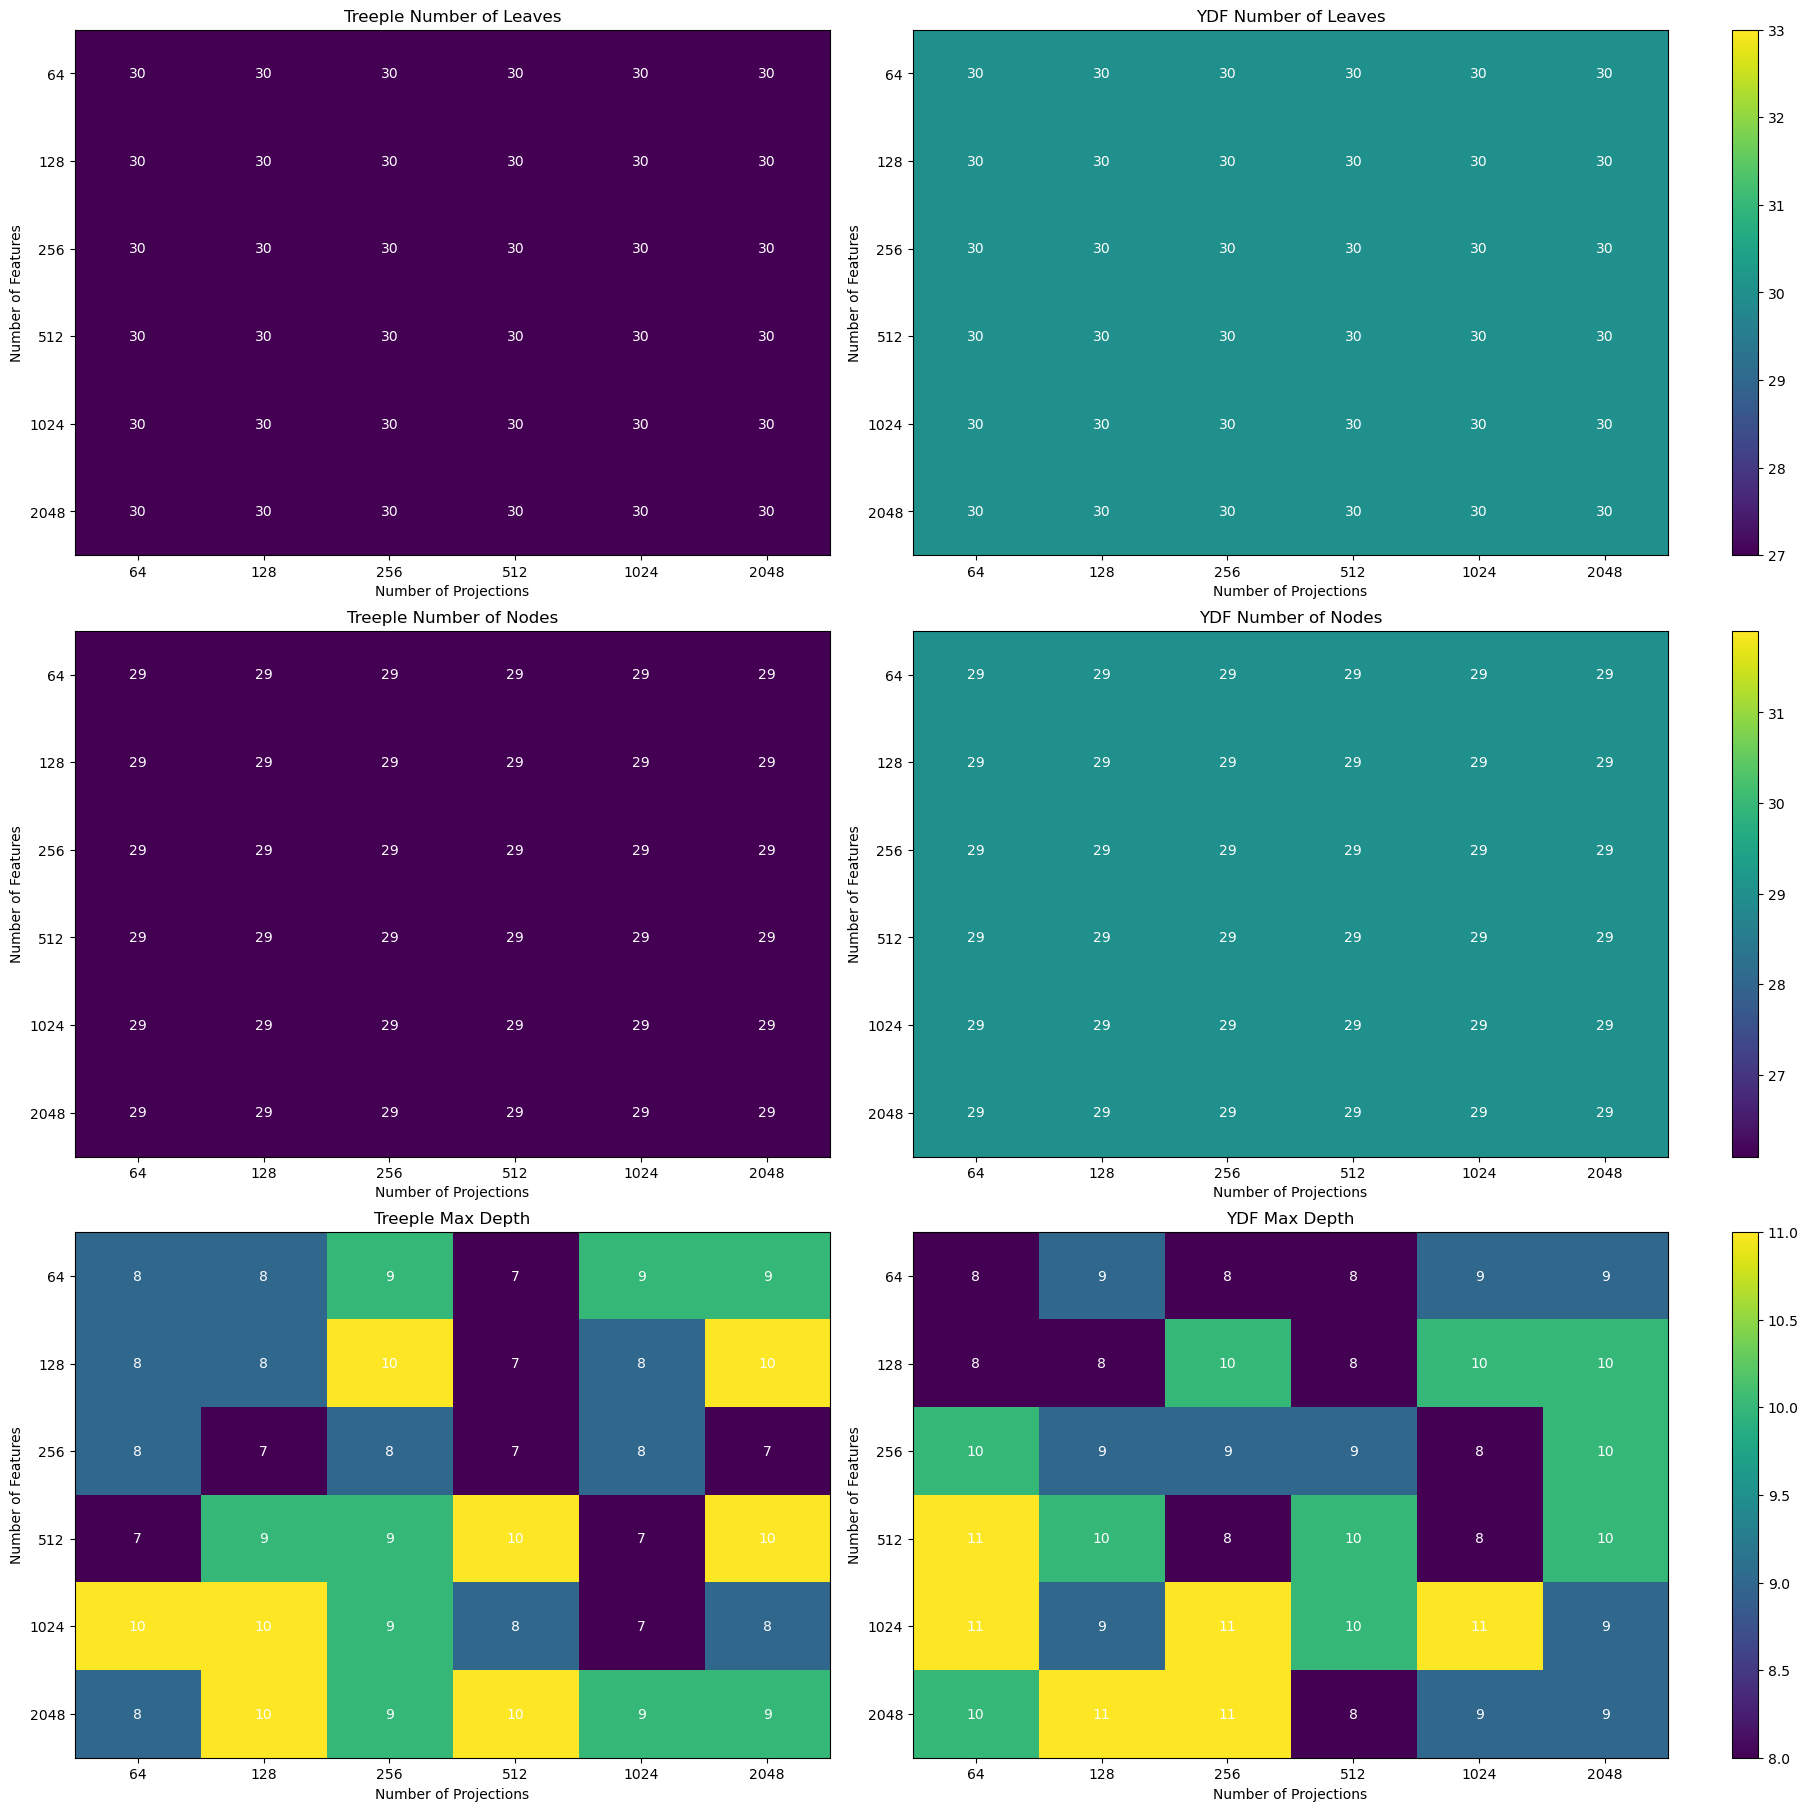

In [164]:
fig, axes = plt.subplots(3, 2, figsize=(18, 18), constrained_layout=True)

# Create a list to store colorbars for each row
colorbars = []

# Titles for each heatmap
titles = [
    "Treeple Number of Leaves",
    "YDF Number of Leaves",
    "Treeple Number of Nodes",
    "YDF Number of Nodes",
    "Treeple Max Depth",
    "YDF Max Depth"
]

# Data for each heatmap
heatmap_data = [
    num_leaves_treeple,
    num_leaves_ydf,
    num_noded_treeple,
    num_noded_ydf,
    max_dept_treeple,
    max_dept_ydf
]

# Plot each heatmap
for i, ax in enumerate(axes.flat):
    cax = ax.imshow(heatmap_data[i], cmap='viridis', aspect='auto')
    ax.set_title(titles[i])
    ax.set_xlabel('Number of Projections')
    ax.set_ylabel('Number of Features')
    ax.set_xticks(np.arange(len(n_rows)))
    ax.set_yticks(np.arange(len(n_columns)))
    ax.set_xticklabels(n_rows)
    ax.set_yticklabels(n_columns)
    
    # Annotate each cell with its value
    for row in range(len(n_columns)):
        for col in range(len(n_rows)):
            ax.text(col, row, f"{heatmap_data[i][row, col]:.0f}", ha='center', va='center', color='white')
    
    # Add colorbar for each row
    if i % 2 == 1:  # Add colorbar after the second column of each row
        colorbar = fig.colorbar(cax, ax=axes[i // 2, :], orientation='vertical', fraction=0.02, pad=0.04)
        colorbars.append(colorbar)

plt.show()

# Titles for each heatmap
titles = [
    "Treeple Number of Leaves",
    "YDF Number of Leaves",
    "Treeple Number of Nodes",
    "YDF Number of Nodes",
    "Treeple Max Depth",
    "YDF Max Depth"
]

# Data for each heatmap
heatmap_data = [
    num_leaves_treeple,
    num_leaves_ydf,
    num_noded_treeple,
    num_noded_ydf,
    max_dept_treeple,
    max_dept_ydf
]

# Plot each heatmap
for i, ax in enumerate(axes.flat):
    cax = ax.imshow(heatmap_data[i], cmap='viridis', aspect='auto')
    ax.set_title(titles[i])
    ax.set_xlabel('Number of Projections')
    ax.set_ylabel('Number of Features')
    ax.set_xticks(np.arange(len(n_rows)))
    ax.set_yticks(np.arange(len(n_columns)))
    ax.set_xticklabels(n_rows)
    ax.set_yticklabels(n_columns)
    
    # Annotate each cell with its value
    for row in range(len(n_columns)):
        for col in range(len(n_rows)):
            ax.text(col, row, f"{heatmap_data[i][row, col]:.0f}", ha='center', va='center', color='white')

# Add a shared colorbar
fig.colorbar(cax, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)

plt.show()